<a href="https://colab.research.google.com/github/Emmanuelludo/kaggle_notebooks/blob/main/Danone_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd


import os
import zipfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import seaborn as sns

from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, f1_score, accuracy_score, recall_score
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler



# CLassifiers in Use
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier as xgb , XGBRFClassifier as xgbrf
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import shap




#ignore warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed=313

In [3]:
#Importing Dataset

!wget -q -P /content/ https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Danone+Hackathon+Mexico/data/train_products.json

!wget -q -P /content/ https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Danone+Hackathon+Mexico/data/test_products.json

In [4]:
#Data Directories

train_dir = '/content/train_products.json'
test_dir = '/content/test_products.json'



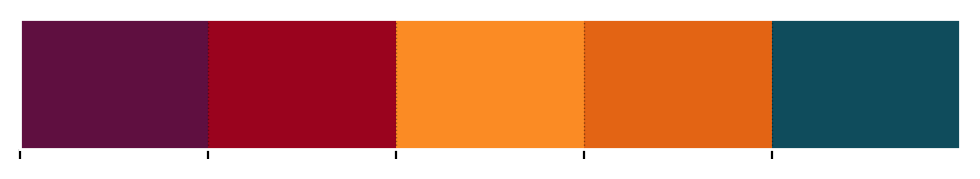

In [5]:
#Plotting Parameters
plt.style.use("ggplot")  #seaborn-whitegrid
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

COLOR = 'black'
mpl.rcParams.update({'text.color' : COLOR,
                     'axes.labelcolor' : COLOR,
                     'xtick.color' : COLOR,
                     'ytick.color' : COLOR,
                     'axes.labelsize' : 18,
                     'axes.titlesize' : 18,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'axes.grid' : True,
                     'grid.color' : 'k',
                     'grid.alpha' : 0.4,
                     'grid.linestyle' : ':',
                     'grid.linewidth' : 0.5})

palette = ["#5f0f40","#9a031e","#fb8b24","#e36414","#0f4c5c"]
sns.palplot(sns.color_palette(palette))
plt.show()


In [6]:
#Read Data into Dataframe
train_df = pd.read_json(train_dir)
test_df = pd.read_json(test_dir)

train_df=train_df.T
test_df=test_df.T

In [7]:
train_df.sample(15)


,name,brand,generic_name,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,...,nutrition_grade,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
3591,Provolone cheese,"Kraft, Heinz",unknown,"[en:dairies, en:fermented-foods, en:fermented-...",0,[en:united-states],{'en:unknown': 100},"[{'id': 'en:pasteurised-milk', 'percent_estima...",0,unknown,...,d,[en:unknown],1,4.9700701,0.0066875618,0.03557378,0.26266115,0.42112177,0.21150363,3
16600,Paëlla royale,"Marque Repere,Côté Table",unknown,"[en:meats-and-their-products, en:meals, en:mea...",0,[en:france],"{'en:unknown': 78.65, 'en:european-union': 21.35}","[{'id': 'en:water', 'percent_estimate': 31.55,...",9,unknown,...,b,[en:unknown],1,2.139004,0.017733,0.037393,0.186227,0.326605,0.35053,3
14580,Sauce Madère,"Marque Repère,Rustica",unknown,"[en:condiments, en:sauces, en:madere-sauces, e...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:water', 'percent_estimate': 50, 'p...",2,unknown,...,c,[en:unknown],0,4.399937,0.017733,0.039628,0.177364,0.185623,0.216798,3
8924,Salchichas Frankfurt vegetales,"Garden Gourmet,Nestlé",unknown,"[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:belgium, en:spain]",{'en:unknown': 100},"[{'id': 'en:water', 'percent_estimate': 50, 'p...",1,unknown,...,c,[en:unknown],1,4.4104315,0.092756569,0.037393191,0.23305521,0.25444296,0.20293278,4
10468,Pollo asado,Eroski,unknown,"[en:meats-and-their-products, en:meats, en:chi...",0,[en:spain],{'en:unknown': 100},unknown,unknown,unknown,...,b,[en:unknown],1,4.142584,0.006688,0.036974,0.275642,0.824163,0.233039,3
4757,Thon blanc entier,"Pêche Océan,Marque Repère",unknown,"[en:seafood, en:canned-foods, en:fishes, en:fa...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:albacore', 'percent_estimate': 66....",0,unknown,...,c,[en:metal],0,7.29133,0.006688,0.036974,0.275642,0,0.787359,4
2898,Yogur bifidus con trozos,Carrefour,unknown,"[en:dairies, en:fermented-foods, en:desserts, ...",0,[en:spain],{'en:unknown': 100},unknown,unknown,unknown,...,b,[en:unknown],1,1.530274,0.006688,0.035574,0.180553,0.148688,0.236482,1
5495,Sauce aïoli - pot,"Rustica,Marque Repère",unknown,"[en:condiments, en:sauces, en:aiolis, en:groce...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:water', 'percent_estimate': 48.096...",3,unknown,...,d,[en:unknown],1,0.657146,0.006688,0.039628,0.177364,0.223754,0.32476,3
1084,Sélections Fruitées façon Fraise Melba,"Nestlé,La Laitière",unknown,"[en:desserts, en:frozen-foods, en:frozen-desse...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:water', 'percent_estimate': 35.25,...",13,unknown,...,c,[en:plastic],1,0.234009,0.025304,0.064524,0.262841,0.180291,0.302605,1
12309,"Rama zum Streichen, Backen & Kochen","Rama,Unilever",unknown,"[en:plant-based-foods-and-beverages, en:plant-...",0,[en:germany],{'en:unknown': 100},"[{'from_palm_oil': 'maybe', 'id': 'en:vegetabl...",5,unknown,...,d,[en:plastic],1,1.3544717,0.0066875618,0.037049036,0.18055336,0.21058322,0.32446016,2


## Exploratory Data Analysis


In [8]:
print(f'Training Dataset size is {train_df.shape}')
print(f'Testing Dataset size is {test_df.shape}')

Training Dataset size is (20835, 28)
Testing Dataset size is (1272, 27)


In [9]:
train_df.describe().T

,count,unique,top,freq
name,20835,16723,unknown,328
brand,20835,2153,Carrefour,6815
generic_name,20835,264,unknown,18624
categories_hierarchy,20835,6930,"[en:plant-based-foods-and-beverages, en:plant-...",328
is_beverage,20835,2,0,18022
selling_countries,20835,672,[en:france],11681
ingredient_origins,20835,1372,{'en:unknown': 100},15010
ingredients,20835,13964,unknown,5154
additives_count,20835,22,0,6017
calcium_100g,20835,425,unknown,19888


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20835 entries, 0 to 20834
Data columns (total 28 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   name                                                  20835 non-null  object
 1   brand                                                 20835 non-null  object
 2   generic_name                                          20835 non-null  object
 3   categories_hierarchy                                  20835 non-null  object
 4   is_beverage                                           20835 non-null  object
 5   selling_countries                                     20835 non-null  object
 6   ingredient_origins                                    20835 non-null  object
 7   ingredients                                           20835 non-null  object
 8   additives_count                                       20835 non-nu

In [11]:
train=train_df.replace({'unknown':np.nan})
train.describe()
# train_df.sample(15)

,is_beverage,additives_count,non_recyclable_and_non_biodegradable_materials_count,ecoscore_grade
count,20835.000000,15681.000000,20835.000000,20835.000000
mean,0.135013,1.907531,0.740725,2.149028
std,0.341746,2.360927,0.457327,1.221355
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,2.000000
75%,0.000000,3.000000,1.000000,3.000000
max,1.000000,20.000000,4.000000,4.000000


In [12]:
train_df.describe().T

,count,unique,top,freq
name,20835,16723,unknown,328
brand,20835,2153,Carrefour,6815
generic_name,20835,264,unknown,18624
categories_hierarchy,20835,6930,"[en:plant-based-foods-and-beverages, en:plant-...",328
is_beverage,20835,2,0,18022
selling_countries,20835,672,[en:france],11681
ingredient_origins,20835,1372,{'en:unknown': 100},15010
ingredients,20835,13964,unknown,5154
additives_count,20835,22,0,6017
calcium_100g,20835,425,unknown,19888


In [13]:
train.sample(10)

,name,brand,generic_name,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,...,nutrition_grade,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
2189,Saumon Atlantique,Carrefour,NaN,"[en:seafood, en:fishes, en:fatty-fishes, en:sa...",0,[en:morocco],{'en:norway': 100},NaN,NaN,NaN,...,d,[en:unknown],1,6.901839,0.006688,0.022329,0.521356,0.310197,1.003897,4
17871,Monrillac pineau des charentes,"Monrillac, Carrefour",NaN,"[en:beverages, en:alcoholic-beverages, en:wine...",1,[en:france],{'en:france': 100},[{'id': 'fr:le-pineau-des-charentes-est-le-res...,0.0,NaN,...,NaN,[en:glass],0,0.351216,0.006688,0.035507,0.47839,0.040838,0.310572,2
9307,Le Brownie goût chocolat noisette,"P'tit Déli,Marque Repère",NaN,"[en:snacks, en:desserts, en:sweet-snacks, en:b...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:fresh-egg', 'percent_estimate': 22...",5.0,NaN,...,d,"[en:cardboard, en:plastic]",1,2.867378,0,0.019531,0.288149,3.926895,0.17497,3
13663,Pignons de pin,"Couleurs Vives,Marque Repère",NaN,"[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:china': 100},"[{'id': 'en:pine-nuts', 'percent_estimate': 10...",0.0,NaN,...,b,[en:plastic],1,3.521965,0,0.022707,0.265399,0.194501,0.159195,3
15576,Madeleines coquilles,"P'tit Déli,Marque Repère",NaN,"[en:snacks, en:desserts, en:sweet-snacks, en:b...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:wheat-flour', 'percent': 35, 'perc...",5.0,NaN,...,d,[en:plastic],1,1.215571,0,0.019531,0.288188,0.264734,0.160498,1
13044,Piperade à la basquaise,Carrefour,NaN,"[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:toma...",2.0,NaN,...,a,[en:metal],0,0.572314,0.017733,0.037393,0.185746,0.187062,0.274936,1
13641,Papillotes lait,"Esprit de Fête,Carrefour",NaN,"[en:snacks, en:sweet-snacks, en:cocoa-and-its-...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:sugar', 'percent_estimate': 36.2, ...",1.0,NaN,...,e,[en:plastic],1,0.904584,0,0.017321,0.271135,0.336585,0.200265,3
8471,"MIX Epeautre, lentilles corail, graines de sésame","Carrefour Bio, Carrefour",NaN,"[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:france, en:italy, en:spain]",{'en:european-union-and-non-european-union': 100},"[{'id': 'fr:ble-d-epeautre-precuit', 'labels':...",0.0,NaN,...,a,[en:plastic],1,0.273291,0,0.019531,0.192124,0.176723,0.128381,1
433,Ketchup,"Thomy,Nestlé",NaN,"[en:condiments, en:sauces, en:tomato-sauces, e...",0,[en:switzerland],{'en:unknown': 100},"[{'id': 'fr:puree-de-tomates-reconstituee', 'p...",0.0,NaN,...,c,[en:pet-polyethylene-terephthalate],0,0.216447,0.006688,0.039628,0.226134,0.20168,0.254524,0
13117,Vinaigre Balsamique de Modène,"En Cuisine, Carrefour",NaN,"[en:condiments, en:vinegars, en:balsamic-vineg...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:wine-vinegar', 'percent_estimate':...",0.0,NaN,...,NaN,[en:unknown],1,0.28931,0,0.015377,0.565831,0.116157,0.190348,1


In [14]:
train.head()


,name,brand,generic_name,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,...,nutrition_grade,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
0,Pommes duchesse,"Pom lisse,Pom'Lisse, Marque Repère",NaN,"[en:frozen-foods, en:frozen-fried-potatoes, en...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:potato', 'percent': 82, 'percent_e...",1.0,NaN,...,b,[en:plastic],1,1.405794,0.122097,0.151978,0.400866,0.1234,0.344651,2
1,Bûche pâtissière à la crème au beurre,"Esprit de Fête,Carrefour",NaN,"[en:snacks, en:desserts, en:sweet-snacks, en:f...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:glucose-syrup', 'percent_estimate'...",10.0,NaN,...,e,"[en:cardboard, en:plastic]",1,1.772009,0,0.019531,0.288156,5.215055,0.171567,3
2,Cini Minis,"Nestlé, Nestlé",,"[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:austria, en:france, en:germany, en:spain, ...",{'en:unknown': 100},"[{'id': 'en:whole-wheat-flour', 'percent': 37,...",3.0,0.635,...,d,"[en:paperboard, en:plastic]",1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3
3,Cuor di fette Carrefour,Carrefour,NaN,"[en:dairies, en:fermented-foods, en:fermented-...",0,[en:italy],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:chee...",2.0,NaN,...,e,[en:plastic],1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3
4,Curry,"Carrefour,Groupe Carrefour",NaN,"[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:turmeric', 'percent_estimate': 55....",0.0,NaN,...,NaN,"[en:glass, en:plastic, en:unknown]",0,7.918371,0,0.015709,0.47839,0.445327,0.334988,4


In [15]:
train.isnull().sum()

name                                                      328
brand                                                       0
generic_name                                            18624
categories_hierarchy                                        0
is_beverage                                                 0
selling_countries                                           3
ingredient_origins                                          0
ingredients                                              5154
additives_count                                          5154
calcium_100g                                            19888
carbohydrates_100g                                       2277
energy_kcal_100g                                         4842
fat_100g                                                 2335
fiber_100g                                               7522
proteins_100g                                            2278
salt_100g                                                2575
sodium_1

In [16]:
train_df[train.name.isnull()]

,name,brand,generic_name,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,...,nutrition_grade,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
47,unknown,"Tablette d'Or,Marque Repère",,"[en:snacks, en:desserts, en:sweet-snacks, en:c...",0,"[en:france, en:germany, en:reunion, en:tunisia]",{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:pate...",1,unknown,...,e,"[en:heavy-aluminium, en:paper]",0,1.463891,0,0.017321,0.104294,15.259235,0.265547,3
55,unknown,"Tradilège,Marque Repère,Scamark (Filiale E. Le...",unknown,"[en:meats-and-their-products, en:meats, en:pre...",0,[en:france],{'en:france': 100},[{'id': 'en:superior-sausage-cooked-with-garli...,9,unknown,...,d,[en:unknown],0,9.998261,0.092757,0.037393,0.524346,0.718456,0.214091,3
104,unknown,"Knorr,Unilever",unknown,"[en:plant-based-foods-and-beverages, en:plant-...",0,[en:sweden],{'en:unknown': 100},"[{'id': 'en:salt', 'percent_estimate': '54.545...",0,unknown,...,unknown,[en:plastic],1,4.7634249,0,0.015708527,0.47839023,0.2624518,0.3346387,4
110,unknown,Carrefour,,"[en:dairies, en:fermented-foods, en:fermented-...",0,"[en:belgium, en:france, en:spain]",{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:mozz...",0,unknown,...,d,[en:plastic],1,3.849477,0.006688,0.035574,0.262661,0.297043,0.211504,2
117,unknown,Nestlé,,"[en:cocoa-and-its-products, en:cocoa-and-choco...",0,"[en:bulgaria, en:france]",{'en:unknown': 100},[{'id': 'xx:pазтворима-какаова-напитка-с-добав...,0,unknown,...,unknown,[en:plastic],1,7.467976,0,0.015709,0.47839,19.052315,0.469039,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20548,unknown,"Terre d'Italia, Carrefour",unknown,"[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:france, en:italy]",{'en:unknown': 100},unknown,unknown,unknown,...,d,[en:unknown],1,0.39711,0,0.004855,0.110178,0.183442,0.128559,1
20561,unknown,"Thomy,Nestlé",,"[en:condiments, en:sauces, en:mayonnaises, en:...",0,"[en:croatia, en:montenegro, en:serbia]",{'en:unknown': 100},"[{'from_palm_oil': 'no', 'id': 'en:sunflower-o...",0,unknown,...,e,"[xx:90-c-ldpe, en:hdpe-high-density-polyethylene]",1,1.965186,0.006688,0.039628,0.240192,0.391958,0.366225,3
20570,unknown,Nestlé,unknown,"[en:beverages, en:dairies, en:dried-products, ...",1,[en:senegal],{'en:unknown': 100},"[{'id': 'en:sugar', 'percent_estimate': 55.555...",1,unknown,...,unknown,[en:unknown],1,14.597797,0,0.015516,0.099604,0,0.107534,4
20743,unknown,Nestlé,unknown,"[en:snacks, en:sweet-snacks, en:cocoa-and-its-...",0,"[en:belgium, en:france]",{'en:unknown': '100'},"[{'has_sub_ingredients': 'yes', 'id': 'en:milk...",4,unknown,...,e,[en:unknown],1,2.8278069,0,0.017321188,0.10429359,6.4912047,0.2759754,4


In [17]:
train.brand.nunique()

2153

In [18]:
# print(f'Duplicates: {train.duplicated().sum()}')
# train[train.duplicated()]

In [19]:
# train.duplicated()

##Visualization

<Axes: xlabel='is_beverage', ylabel='Percent'>

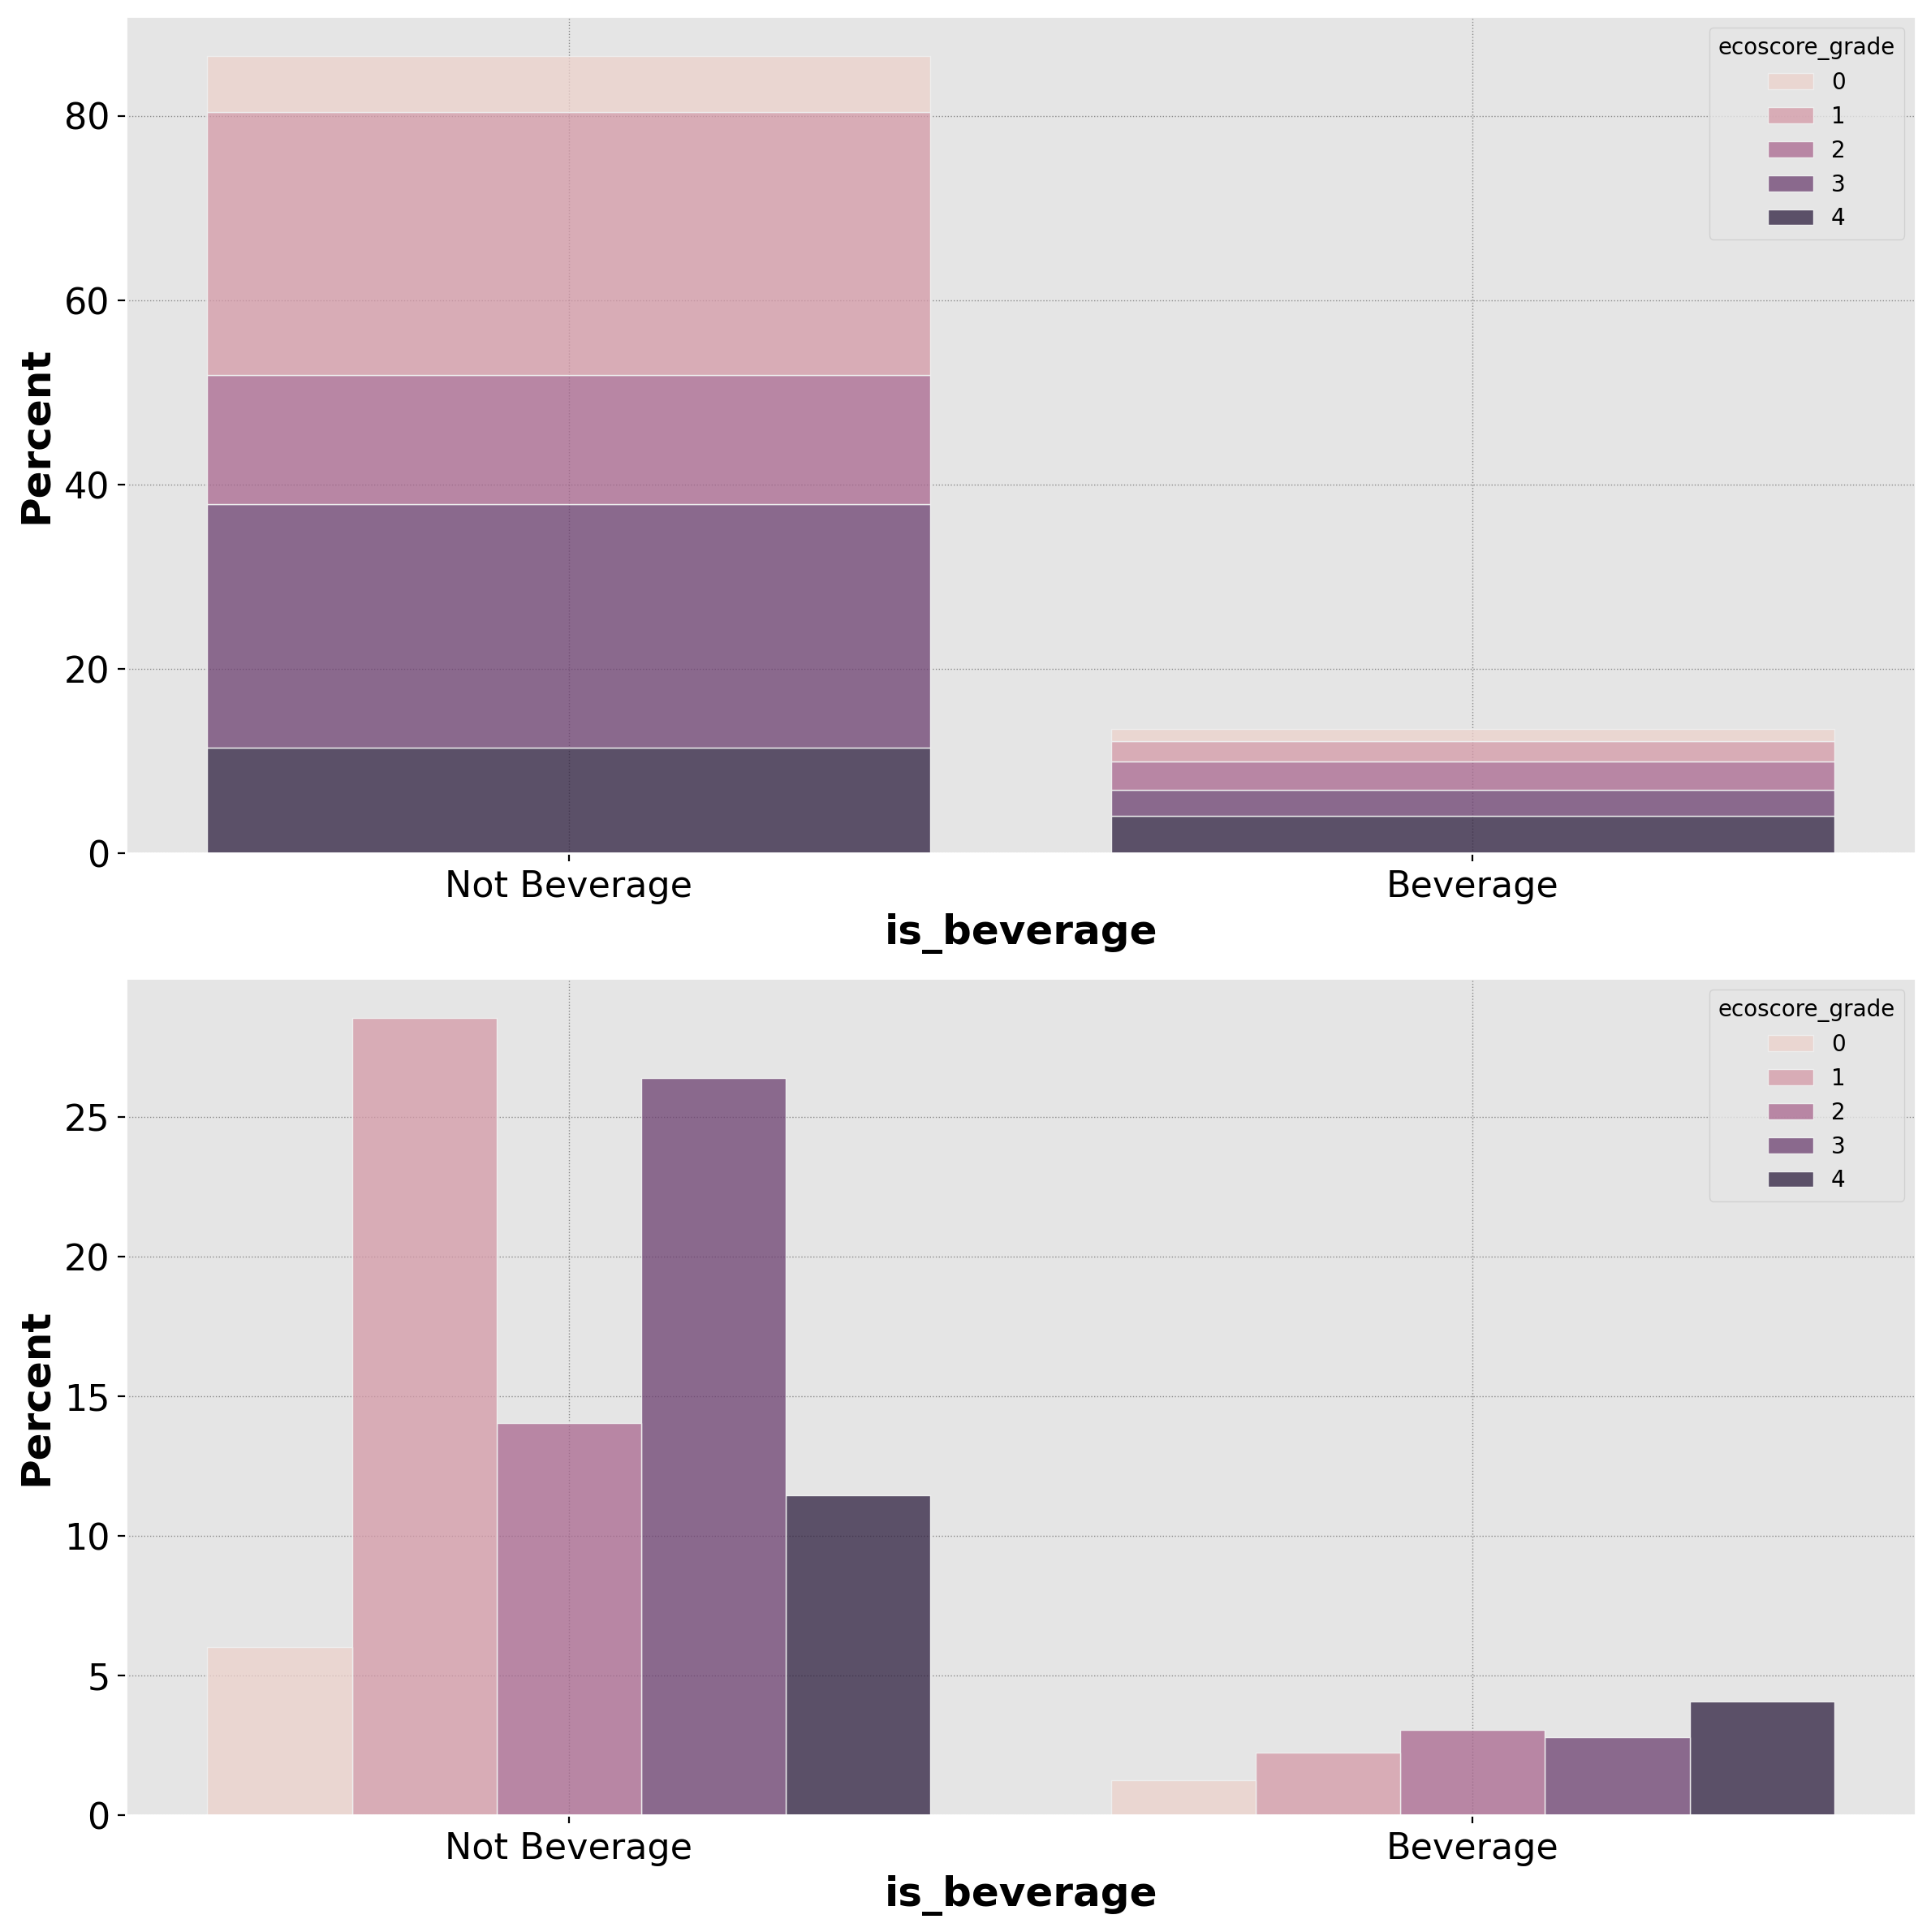

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
beverage_map =  {0:'Not Beverage',1:'Beverage'}
beverage = train.is_beverage.map(beverage_map)

sns.histplot(data=train, x =beverage, hue="ecoscore_grade", multiple="stack", shrink=.8, ax=ax1, stat= 'percent', )

sns.histplot(data=train, x = beverage, multiple="dodge", shrink=.8, hue="ecoscore_grade", ax=ax2, stat= 'percent', )

In [21]:
train.columns

Index(['name', 'brand', 'generic_name', 'categories_hierarchy', 'is_beverage',
       'selling_countries', 'ingredient_origins', 'ingredients',
       'additives_count', 'calcium_100g', 'carbohydrates_100g',
       'energy_kcal_100g', 'fat_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'sugars_100g', 'nutrition_grade',
       'packaging_materials',
       'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'ecoscore_grade'],
      dtype='object')

In [22]:
#drop nutritional columns as irrelevant in ecoscore calculations
train.drop(['additives_count', 'calcium_100g',
       'carbohydrates_100g', 'energy_kcal_100g', 'fat_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g',
       'nutrition_grade','generic_name'],axis = 1,inplace = True)

train.columns


Index(['name', 'brand', 'categories_hierarchy', 'is_beverage',
       'selling_countries', 'ingredient_origins', 'ingredients',
       'packaging_materials',
       'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'ecoscore_grade'],
      dtype='object')

In [23]:
train.head(5)

,name,brand,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
0,Pommes duchesse,"Pom lisse,Pom'Lisse, Marque Repère","[en:frozen-foods, en:frozen-fried-potatoes, en...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:potato', 'percent': 82, 'percent_e...",[en:plastic],1,1.405794,0.122097,0.151978,0.400866,0.1234,0.344651,2
1,Bûche pâtissière à la crème au beurre,"Esprit de Fête,Carrefour","[en:snacks, en:desserts, en:sweet-snacks, en:f...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:glucose-syrup', 'percent_estimate'...","[en:cardboard, en:plastic]",1,1.772009,0,0.019531,0.288156,5.215055,0.171567,3
2,Cini Minis,"Nestlé, Nestlé","[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:austria, en:france, en:germany, en:spain, ...",{'en:unknown': 100},"[{'id': 'en:whole-wheat-flour', 'percent': 37,...","[en:paperboard, en:plastic]",1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3
3,Cuor di fette Carrefour,Carrefour,"[en:dairies, en:fermented-foods, en:fermented-...",0,[en:italy],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:chee...",[en:plastic],1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3
4,Curry,"Carrefour,Groupe Carrefour","[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:turmeric', 'percent_estimate': 55....","[en:glass, en:plastic, en:unknown]",0,7.918371,0,0.015709,0.47839,0.445327,0.334988,4


In [24]:
type(train.selling_countries[10202])

list

In [25]:
train.head(5)

,name,brand,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
0,Pommes duchesse,"Pom lisse,Pom'Lisse, Marque Repère","[en:frozen-foods, en:frozen-fried-potatoes, en...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:potato', 'percent': 82, 'percent_e...",[en:plastic],1,1.405794,0.122097,0.151978,0.400866,0.1234,0.344651,2
1,Bûche pâtissière à la crème au beurre,"Esprit de Fête,Carrefour","[en:snacks, en:desserts, en:sweet-snacks, en:f...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:glucose-syrup', 'percent_estimate'...","[en:cardboard, en:plastic]",1,1.772009,0,0.019531,0.288156,5.215055,0.171567,3
2,Cini Minis,"Nestlé, Nestlé","[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:austria, en:france, en:germany, en:spain, ...",{'en:unknown': 100},"[{'id': 'en:whole-wheat-flour', 'percent': 37,...","[en:paperboard, en:plastic]",1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3
3,Cuor di fette Carrefour,Carrefour,"[en:dairies, en:fermented-foods, en:fermented-...",0,[en:italy],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:chee...",[en:plastic],1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3
4,Curry,"Carrefour,Groupe Carrefour","[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:turmeric', 'percent_estimate': 55....","[en:glass, en:plastic, en:unknown]",0,7.918371,0,0.015709,0.47839,0.445327,0.334988,4


In [26]:
# f = lambda x: 'code_{}'.format(x + 1)
# pd.DataFrame(
#     train.selling_countries.values.tolist(),
#     train.index, dtype=object
# ).fillna('').rename(columns=f)

In [27]:
countries = {}
for item in train.selling_countries.tolist():
  if item is np.nan:
    continue
  for count in item:
    if count in countries:
      countries[count] += 1
    else:
      countries[count] = 1



In [28]:
countries

{'en:france': 14978,
 'en:austria': 83,
 'en:germany': 505,
 'en:spain': 4364,
 'en:switzerland': 630,
 'en:italy': 1383,
 'en:poland': 359,
 'en:united-states': 521,
 'en:argentina': 86,
 'en:bolivia': 66,
 'en:chile': 32,
 'en:paraguay': 17,
 'en:uruguay': 15,
 'en:norway': 39,
 'en:mexico': 134,
 'en:belgium': 1220,
 'en:canada': 147,
 'en:reunion': 142,
 'en:tunisia': 33,
 'en:united-kingdom': 180,
 'en:sweden': 89,
 'en:thailand': 80,
 'en:hungary': 47,
 'en:bulgaria': 39,
 'en:luxembourg': 35,
 'en:romania': 228,
 'en:croatia': 23,
 'en:philippines': 7,
 'en:portugal': 109,
 'en:finland': 33,
 'en:czech-republic': 84,
 'en:martinique': 42,
 'en:serbia': 43,
 'en:morocco': 86,
 'en:brazil': 56,
 'en:netherlands': 79,
 'en:algeria': 26,
 'en:japan': 10,
 'en:colombia': 47,
 'en:french-polynesia': 38,
 'en:slovakia': 23,
 'en:egypt': 1,
 'en:guadeloupe': 65,
 'en:ireland': 44,
 'en:espagne': 14,
 'en:hong-kong': 18,
 'en:costa-rica': 2,
 'en:greece': 16,
 'en:francia': 8,
 'en:polog

In [29]:
len(countries)

177

In [30]:
#getting countries to one language

trans_c = [count for count in countries if count[:2]!='en']

print(len(trans_c))
trans_c


29


['fr:francia',
 'fr:spagna',
 'fr:estados-unidos',
 'fr:guadalupe',
 'fa:espagne',
 'fr:grecia',
 'fr:marruecos',
 'fr:belgie',
 'fr:belgica',
 'fr:suiza',
 'fr:polonia',
 'fr:espanya',
 'fr:frankreich',
 'fr:deutschland',
 'fr:spanien',
 'fr:polinesia-francesa',
 'fr:francja',
 'fr:polska',
 'fr:franța',
 'fr:martinica',
 'es:espagne',
 'nl:belgie',
 'fr:alemania',
 'es:espanha',
 'es:franca',
 'fr:belgia',
 'fr:niemcy',
 'fr:tailandia',
 'ar:espagne']

In [31]:
# Mapping of coutries to one english form
countries_map = {'fr:francia':'en:france',
 'fr:spagna':'en:spain',
 'fr:estados-unidos':'en:united-states',
 'fr:guadalupe':'en:guadeloupe',
 'fa:espagne':'en:spain',
 'fr:grecia':'en:greece',
 'fr:marruecos':'en:morocco',
 'fr:belgie':'en:belgium',
 'fr:belgica':'en:belgium',
 'fr:suiza':'en:switzerland',
 'fr:polonia':'en:poland',
 'fr:espanya':'en:spain',
 'fr:frankreich':'en:france',
 'fr:deutschland':'en:germany',
 'fr:spanien':'en:spain',
 'fr:polinesia-francesa':'en:french-polynesia',
 'fr:francja':'en:france',
 'fr:polska':'en:poland',
 'fr:franța':'en:france',
 'fr:martinica':'en:martinique',
 'es:espagne':'en:spain',
 'nl:belgie':'en:belgium',
 'fr:alemania':'en:germany',
 'es:espanha':'en:spain',
 'es:franca':'en:france',
 'fr:belgia':'en:belgium',
 'fr:niemcy':'en:germany',
 'fr:tailandia':'en:thailand',
 'ar:espagne':'en:spain',
 'en:espagne':'en:spain',
 'en:francia': 'en:france',
 'en:pologne': 'en:poland',
 'en:spagna': 'en:spain',
 'en:belgique': 'en:belgium',
 'en:roumanie': 'en:romania',
 'en:nederland': 'en:netherlands',
 'en:autriche': 'en:austria',
 'en:etats-unis': 'en:united-states',
 'en:en': 'en:united-kingdom',
 'en:royaume-uni':'en:united-kingdom',
 'en:србија':'en:serbia',
 'en:deutschland':'en:germany',
 'en:frankreich': 'en:france',
 'en:east-germany': 'en:germany',
 'en:belgien': 'en:belgium',
 'en:frankrike':  'en:france',
 'en:nederlanderna': 'en:netherlands',
 'en:norge': 'en:norway',
 'en:sverige': 'en:sweden',
 'en:tyskland': 'en:germany',
 'en:svizzera':'en:switzerland',
 'en:belgica': 'en:belgium',
 'en:andorra-francia-espana': 'en:andorra',
 'es:espanha': 'en:spain',
 'es:franca': 'en:france',
 'en:schweiz': 'en:switzerland',
 'en:marruecos':'en:morocco'}

In [32]:
#create a dictionary of countries to be chaged and their values
tbc = {count:countries[count] for count in countries if count in countries_map}
print(len(tbc))
tbc


55


{'en:espagne': 14,
 'en:francia': 8,
 'en:pologne': 7,
 'en:spagna': 1,
 'en:belgique': 6,
 'fr:francia': 62,
 'fr:spagna': 3,
 'fr:estados-unidos': 1,
 'fr:guadalupe': 3,
 'fa:espagne': 1,
 'fr:grecia': 1,
 'fr:marruecos': 3,
 'en:roumanie': 6,
 'en:nederland': 1,
 'fr:belgie': 2,
 'fr:belgica': 7,
 'fr:suiza': 3,
 'en:autriche': 1,
 'en:etats-unis': 1,
 'en:en': 6,
 'fr:polonia': 6,
 'fr:espanya': 2,
 'fr:frankreich': 3,
 'en:royaume-uni': 1,
 'fr:deutschland': 1,
 'fr:spanien': 1,
 'fr:polinesia-francesa': 3,
 'fr:francja': 3,
 'fr:polska': 3,
 'en:србија': 1,
 'fr:franța': 1,
 'fr:martinica': 1,
 'es:espagne': 1,
 'nl:belgie': 1,
 'en:deutschland': 3,
 'en:frankreich': 2,
 'fr:alemania': 1,
 'en:marruecos': 2,
 'es:espanha': 1,
 'es:franca': 1,
 'en:schweiz': 3,
 'en:east-germany': 1,
 'en:belgien': 1,
 'en:frankrike': 1,
 'en:nederlanderna': 1,
 'en:norge': 1,
 'en:sverige': 2,
 'en:tyskland': 1,
 'fr:belgia': 1,
 'fr:niemcy': 1,
 'en:belgica': 1,
 'en:andorra-francia-espana': 1,


In [33]:
compact = {}
for country,value in tbc.items():
  #swap country for country in country map
  country = countries_map[country]
  if country in compact:
    #add values to new dictionary
    compact[country] += value
  else:
    compact[country] = value
print(len(compact))
compact

21


{'en:spain': 25,
 'en:france': 81,
 'en:poland': 16,
 'en:belgium': 19,
 'en:united-states': 2,
 'en:guadeloupe': 3,
 'en:greece': 1,
 'en:morocco': 5,
 'en:romania': 6,
 'en:netherlands': 2,
 'en:switzerland': 7,
 'en:austria': 1,
 'en:united-kingdom': 7,
 'en:germany': 8,
 'en:french-polynesia': 3,
 'en:serbia': 1,
 'en:martinique': 1,
 'en:norway': 1,
 'en:sweden': 2,
 'en:andorra': 1,
 'en:thailand': 1}

In [34]:
#Remove country keys to be replaced
for count in tuple(countries):
  if count in countries_map:
    countries.pop(count,None)

len(countries)

122

In [35]:
# Add new dict to old country dict
# countries_f = dict(countries,**compact)
# len(countries)

In [36]:
ing_origins = train.ingredient_origins.apply(pd.Series)

In [37]:
ing_origins.isnull().sum()

en:unknown              3925
en:ireland             20823
en:norway              20776
en:european-union      20064
en:faroe-islands       20830
                       ...  
en:papua-new-guinea    20834
en:guam                20834
en:slovakia            20834
en:swaziland           20834
en:benin               20834
Length: 109, dtype: int64

In [38]:
#rename cols withot the en prefix
cols = tuple(ing_origins.columns)
rename_map  = {count:count[3:] for count in cols}
# rename_map

In [39]:
# ll=[]
# for count in rename_map.values():
#   ll.append(count)
# ll

In [40]:
origin_map = {'unknown':0,
 'ireland':0,
 'norway':62,
 'european-union':8,
 'faroe-islands':86,
 'iceland':61,
 'france':100,
 'netherlands':76,
 'argentina':0,
 'ghana':38,
 'spain':58,
 'european-union-and-non-european-union':8,
 'united-states':0,
 'italy':54,
 'mexico':0,
 'vatican-city':55,
 'canada':0,
 'morocco':72,
 'thailand':0,
 'tanzania':0,
 'philippines':0,
 'germany':63,
 'turkey':6,
 'europe':8,
 'unspecified':0,
 'china':0,
 'united-kingdom':76,
 'ecuador':25,
 'dominican-republic':51,
 'madagascar':0,
 'brazil':0,
 'world':0,
 'chile':0,
 'czech-republic':65,
 'belgium':85,
 'laos':0,
 'hungary':48,
 'ethiopia':17,
 'egypt':33,
 'bolivia':0,
 'lithuania':38,
 'ukraine':15,
 'nicaragua':21,
 'the-bahamas':54,
 'poland':45,
 'switzerland':93,
 'cote-d-ivoire':37,
 'algeria':31,
 'peru':0,
 'sweden':48,
 'colombia':13,
 'new-zealand':0,
 'romania':8,
 'india':0,
 'pakistan':0,
 'serbia':35,
 'tunisia':65,
 'niger':0,
 'greece':24,
 'portugal':46,
 'paraguay':0,
 'finland':42,
 'australia':0,
 'kenya':0,
 'hong-kong':0,
 'eritrea':50,
 'japan':0,
 'honduras':34,
 'sri-lanka':16,
 'bulgaria':15,
 'iran':0,
 'senegal':57,
 'denmark':55,
 'isle-of-man':80,
 'moldova':20,
 'vietnam':0,
 'costa-rica':37,
 'guyana':40,
 'seychelles':34,
 'indonesia':0,
 'uruguay':10,
 'austria':65,
 'russia':0,
 'guatemala':12,
 'greenland':11,
 'burundi':0,
 'uganda':0,
 'federated-states-of-micronesia':0,
 'malawi':0,
 'south-africa':0,
 'azerbaijan':18,
 'albania':46,
 'trinidad-and-tobago':54,
 'suriname':41,
 'el-salvador':29,
 'sao-tome-and-principe':52,
 'israel':58,
 'namibia':3,
 'malaysia':0,
 'croatia':37,
 'slovenia':58,
 'palestinian-territories':62,
 'cameroon':1,
 'cambodia':0,
 'papua-new-guinea':0,
 'guam':0,
 'slovakia':53,
 'swaziland':13,
 'benin':30,
  'saudi-arabia':0,
  'guadeloupe':53 }

In [41]:
# ll.sort()

In [42]:
#create country of origin score
ing_origins = ing_origins.rename(columns=rename_map)



In [43]:
ing_origins = ing_origins.astype(dtype='float16')
test = ing_origins[ing_origins.france > 0]
test

,unknown,ireland,norway,european-union,faroe-islands,iceland,france,netherlands,argentina,ghana,...,croatia,slovenia,palestinian-territories,cameroon,cambodia,papua-new-guinea,guam,slovakia,swaziland,benin
12,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20800,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20811,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20821,NaN,NaN,NaN,NaN,NaN,NaN,97.375,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20826,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
#Calculate score based on Origin
orig_score = []
for index,row in ing_origins.iterrows():
  over = 0
  for count in row.index:
    # Change conditional later
    if row[count] > 0:
      score = (row[count]/100)*origin_map[count]


    else:
      continue
    over += score

  orig_score.append((index,over))
print(len(orig_score))

20835


In [45]:
idx = [x[0] for x in orig_score]
vals = [x[1] for x in orig_score]
ing_series = pd.Series(vals, index=idx)
# ing_series = pd.DataFrame(orig_score).set_index(0)[1]
ing_series

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
20830    100.0
20831      0.0
20832      0.0
20833      0.0
20834      0.0
Length: 20835, dtype: float64

In [46]:
train.head(5)

,name,brand,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
0,Pommes duchesse,"Pom lisse,Pom'Lisse, Marque Repère","[en:frozen-foods, en:frozen-fried-potatoes, en...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:potato', 'percent': 82, 'percent_e...",[en:plastic],1,1.405794,0.122097,0.151978,0.400866,0.1234,0.344651,2
1,Bûche pâtissière à la crème au beurre,"Esprit de Fête,Carrefour","[en:snacks, en:desserts, en:sweet-snacks, en:f...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:glucose-syrup', 'percent_estimate'...","[en:cardboard, en:plastic]",1,1.772009,0,0.019531,0.288156,5.215055,0.171567,3
2,Cini Minis,"Nestlé, Nestlé","[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:austria, en:france, en:germany, en:spain, ...",{'en:unknown': 100},"[{'id': 'en:whole-wheat-flour', 'percent': 37,...","[en:paperboard, en:plastic]",1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3
3,Cuor di fette Carrefour,Carrefour,"[en:dairies, en:fermented-foods, en:fermented-...",0,[en:italy],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:chee...",[en:plastic],1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3
4,Curry,"Carrefour,Groupe Carrefour","[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:turmeric', 'percent_estimate': 55....","[en:glass, en:plastic, en:unknown]",0,7.918371,0,0.015709,0.47839,0.445327,0.334988,4


In [47]:
#Add origin Score to Train DataFrame

train["origin_score"] = ing_series*0.15
train["origin_score"]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
20830    15.0
20831     0.0
20832     0.0
20833     0.0
20834     0.0
Name: origin_score, Length: 20835, dtype: float64

In [48]:
policy_map = {'albania':7,
 'algeria':0,
 'argentina':16,
 'australia':79,
 'austria':92,
 'azerbaijan':0,
 'belgium':74,
 'benin':0,
 'bolivia':0,
 'brazil':13,
 'bulgaria':29,
 'burundi':0,
 'cambodia':0,
 'cameroon':0,
 'canada':68,
 'chile':24,
 'china':0,
 'colombia':17,
 'costa-rica':16,
 'cote-d-ivoire':50,
 'croatia':46,
 'czech-republic':68,
 'denmark':100,
 'dominican-republic':0,
 'ecuador':12,
 'egypt':0,
 'el-salvador':0,
 'eritrea':0,
 'ethiopia':0,
 'europe':29,
 'european-union':29,
 'european-union-and-non-european-union':29,
 'faroe-islands':50,
 'federated-states-of-micronesia':0,
 'finland':90,
 'france':93,
 'germany':85,
 'ghana':0,
 'greece':63,
 'greenland':50,
  'guadeloupe':93,
 'guam':50,
 'guatemala':0,
 'guyana':0,
 'honduras':0,
 'hong-kong':50,
 'hungary':48,
 'iceland':72,
 'india':0,
 'indonesia':0,
 'iran':4,
 'ireland':73,
 'isle-of-man':50,
 'israel':53,
 'italy':68,
 'japan':79,
 'kenya':0,
 'laos':0,
 'lithuania':45,
 'madagascar':0,
 'malawi':0,
 'malaysia':4,
 'mexico':17,
 'moldova':0,
 'morocco':0,
 'namibia':0,
 'netherlands':80,
 'new-zealand':69,
 'nicaragua':0,
 'niger':0,
 'norway':87,
 'pakistan':0,
 'palestinian-territories':50,
 'papua-new-guinea':0,
 'paraguay':0,
 'peru':0,
 'philippines':0,
 'poland':40,
 'portugal':57,
 'romania':50,
 'russia':11,
 'sao-tome-and-principe':50,
  'saudi-arabia':0,
 'senegal':0,
 'serbia':24,
 'seychelles':32,
 'slovakia':60,
 'slovenia':71,
 'south-africa':0,
 'spain':77,
 'sri-lanka':0,
 'suriname':0,
 'swaziland':50,
 'sweden':89,
 'switzerland':97,
 'tanzania':0,
 'thailand':0,
 'the-bahamas':0,
 'trinidad-and-tobago':2,
 'tunisia':0,
 'turkey':0,
 'uganda':0,
 'ukraine':8,
 'united-kingdom':97,
 'united-states':63,
 'unknown':0,
 'unspecified':0,
 'uruguay':7,
 'vatican-city':50,
 'vietnam':50,
 'world':0}

In [49]:
#Calculate score based on Policy Score
pol_score = []
for index,row in ing_origins.iterrows():
  # print(index)
  # print(row.index)
  over = 0
  for count in row.index:
    # Change conditional later
    if row[count] > 0:
      score = (row[count]/100)*policy_map[count]
    else:
      continue
    over += score
  pol_score.append((index,over))
print(len(pol_score))
idx = [x[0] for x in pol_score]
vals = [x[1] for x in pol_score]
pol_series = pd.Series(vals, index=idx)
train["policy_score"] = (pol_series/10)-5
train.sample(15)

20835


,name,brand,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade,origin_score,policy_score
16821,Cassoulet,Carrefour,"[en:canned-foods, en:meats-and-their-products,...",0,[en:france],{'en:european-union-and-non-european-union': 100},"[{'id': 'en:water', 'percent_estimate': 40.15,...",[en:metal],0,0.043099,0.091416,0.019802,0.219307,0.255584,0.143207,0,1.200,-2.100
18077,Jambon sec,"Carrefour Bio,Carrefour","[en:meats-and-their-products, en:meats, en:pre...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:ham', 'labels': 'en:organic', 'per...",[en:unknown],0,15.025307,0.08873,0.046218,0.123766,2.300768,0.278086,4,0.000,-5.000
11133,Jamón serrano reserva,Carrefour,"[en:meats-and-their-products, en:meats, en:pre...",0,[en:spain],{'en:unknown': 100},"[{'id': 'en:ham', 'percent_estimate': 75, 'per...",[en:unknown],1,15.025307,0.08873,0.046218,0.123766,2.300768,0.278086,4,0.000,-5.000
5531,Salsa pizza,Eroski,"[en:condiments, en:sauces, en:pizza-sauces, en...",0,[en:spain],{'en:unknown': 100},NaN,[en:unknown],1,0.232973,0,0.019531,0.110054,0.168029,0.190668,1,0.000,-5.000
18114,Pistaches,Carrefour,"[en:plant-based-foods-and-beverages, en:plant-...",0,[en:belgium],"{'en:united-states': 99, 'en:unknown': 1}","[{'id': 'en:pistachio-nuts', 'origins': 'en:ca...",[en:unknown],1,5.873544,0.321482,0.045413,0.530799,0,0.579912,3,0.000,1.237
262,Acras de morue,Carrefour,"[en:seafood, en:fishes-and-their-products, en:...",0,[en:france],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'fr:chai...","[en:plastic, en:unknown]",0,4.633708,0.092757,0.037393,0.476451,0.589396,0.207977,4,0.000,-5.000
8488,Sauce bolognaise carrefour BIO,"Carrefour BIO, Carrefour","[en:condiments, en:meats-and-their-products, e...",0,"[en:belgium, en:france]",{'en:unknown': 100},NaN,[en:unknown],1,11.465773,0.017733,0.039628,0.177364,0.245984,0.245841,3,0.000,-5.000
13356,Épinards à la Crème fraîche,"Notre Jardin,Marque Repère","[en:plant-based-foods-and-beverages, en:plant-...",0,[en:portugal],{'en:unknown': 100},NaN,[en:unknown],1,1.371921,0.017733,0.037393,0.185746,0.171338,0.224252,1,0.000,-5.000
7235,Riz complet,"Comptoir du Grain,Marque Repère","[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},[{'id': 'en:superior-quality-long-grain-parboi...,[en:cardboard],0,2.158403,0,0.01882,0.265399,0,0.315158,3,0.000,-5.000
7702,Mini pizzas jambon fromage x9,"Marque Repère, Turini","[en:meats-and-their-products, en:frozen-foods,...",0,[en:france],"{'en:unknown': 91, 'en:european-union': 9}","[{'id': 'en:wheat-flour', 'percent_estimate': ...",[en:unknown],1,2.200587,0.092757,0.037393,0.198621,0.314542,0.233436,3,0.108,-4.739


In [50]:
# ing_df = pd.DataFrame(train.ingredients.tolist())

In [51]:
ing_df = pd.DataFrame(train.ingredients)

In [52]:
ings = pd.DataFrame()
for item in ing_df.ingredients.to_list()[:5]:
  inggg =pd.DataFrame(item)
  ings = pd.concat([ings,inggg])
ings

,id,percent,percent_estimate,percent_max,percent_min,rank,text,vegan,vegetarian,from_palm_oil,has_sub_ingredients,ciqual_food_code,processing
0,en:potato,82.0,82.000000,82.000000,82.0,1.0,Pommes de terre,yes,yes,NaN,NaN,NaN,NaN
1,en:rice-flour,NaN,9.000000,11.200000,6.8,2.0,farine de riz,yes,yes,NaN,NaN,NaN,NaN
2,en:sunflower-oil,6.8,6.800000,6.800000,6.8,3.0,huile de tournesol,yes,yes,no,NaN,NaN,NaN
3,en:potato-powder,NaN,1.100000,4.400000,0.0,4.0,pommes de terre déshydratées,yes,yes,NaN,NaN,NaN,NaN
4,en:salt,NaN,0.550000,3.733333,0.0,5.0,sel,yes,yes,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,en:parsley,NaN,2.777778,20.000000,0.0,5.0,persil,yes,yes,NaN,NaN,NaN,NaN
5,en:hot-chili-peppers,NaN,1.388889,16.666667,0.0,6.0,piment fort,yes,yes,NaN,NaN,NaN,NaN
6,en:garlic,NaN,0.694444,14.285714,0.0,7.0,ail,yes,yes,NaN,NaN,NaN,NaN
7,en:fennel,NaN,0.347222,12.500000,0.0,8.0,fenouil,yes,yes,NaN,NaN,NaN,NaN


In [53]:
train.head(5)

,name,brand,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade,origin_score,policy_score
0,Pommes duchesse,"Pom lisse,Pom'Lisse, Marque Repère","[en:frozen-foods, en:frozen-fried-potatoes, en...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:potato', 'percent': 82, 'percent_e...",[en:plastic],1,1.405794,0.122097,0.151978,0.400866,0.1234,0.344651,2,0.0,-5.0
1,Bûche pâtissière à la crème au beurre,"Esprit de Fête,Carrefour","[en:snacks, en:desserts, en:sweet-snacks, en:f...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:glucose-syrup', 'percent_estimate'...","[en:cardboard, en:plastic]",1,1.772009,0,0.019531,0.288156,5.215055,0.171567,3,0.0,-5.0
2,Cini Minis,"Nestlé, Nestlé","[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:austria, en:france, en:germany, en:spain, ...",{'en:unknown': 100},"[{'id': 'en:whole-wheat-flour', 'percent': 37,...","[en:paperboard, en:plastic]",1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3,0.0,-5.0
3,Cuor di fette Carrefour,Carrefour,"[en:dairies, en:fermented-foods, en:fermented-...",0,[en:italy],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:chee...",[en:plastic],1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3,0.0,-5.0
4,Curry,"Carrefour,Groupe Carrefour","[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:turmeric', 'percent_estimate': 55....","[en:glass, en:plastic, en:unknown]",0,7.918371,0,0.015709,0.47839,0.445327,0.334988,4,0.0,-5.0


In [54]:
#Not that many brands parse later
train.brand.str.split(',',expand=True)[0].str.lower().nunique()

604

In [55]:
pack = {}
for item in train.packaging_materials.tolist():
  if item is np.nan:
    continue
  for count in item:
    if count in pack:
      pack[count] += 1
    else:
      pack[count] = 1

In [56]:
pack

{'en:plastic': 6872,
 'en:cardboard': 3326,
 'en:paperboard': 51,
 'en:glass': 994,
 'en:unknown': 11439,
 'en:other-plastics': 8,
 'en:heavy-aluminium': 350,
 'en:tetra-pak': 137,
 'en:paper': 525,
 'en:pp-polypropylene': 192,
 'en:metal': 1084,
 'en:steel': 54,
 'en:hdpe-2-high-density-polyethylene': 11,
 'en:tetra-brik': 20,
 'en:tetra-brik-aseptic': 19,
 'en:pet-polyethylene-terephthalate': 74,
 'en:non-corrugated-cardboard': 33,
 'en:tetra-rex': 1,
 'en:pet-1-polyethylene-terephthalate': 10,
 'en:hdpe-high-density-polyethylene': 32,
 'en:pp-5-polypropylene': 52,
 'en:pure-pak-classic': 6,
 'en:paper-and-plastic': 7,
 'en:recycled-paper': 2,
 'en:other-paper': 1,
 'en:plastic,en:metal': 3,
 'en:cork': 14,
 'en:90': 1,
 'en:ps-polystyrene': 33,
 'en:wood': 39,
 'xx:84-c-pap': 9,
 'en:light-aluminium': 64,
 'es:PEBD 4': 1,
 'en:sig': 5,
 'en:recycled-cardboard': 1,
 'en:ldpe-low-density-polyethylene': 13,
 'en:clear-glass': 13,
 'en:plastic-aluminium': 1,
 'en:pet-transparent': 2,
 '

In [57]:
package = train.packaging_materials.apply(pd.Series)
# package.head(5)

In [58]:
package.sample(15)

,0,1,2,3,4
2486,en:unknown,NaN,NaN,NaN,NaN
9099,en:cardboard,NaN,NaN,NaN,NaN
15439,en:unknown,NaN,NaN,NaN,NaN
4488,en:unknown,NaN,NaN,NaN,NaN
6180,en:plastic,NaN,NaN,NaN,NaN
16406,en:metal,en:glass,en:unknown,NaN,NaN
348,en:unknown,NaN,NaN,NaN,NaN
16802,en:metal,NaN,NaN,NaN,NaN
404,en:unknown,NaN,NaN,NaN,NaN
17036,en:plastic,NaN,NaN,NaN,NaN


In [59]:
len(pack)

80

In [60]:
list(pack.keys())

['en:plastic',
 'en:cardboard',
 'en:paperboard',
 'en:glass',
 'en:unknown',
 'en:other-plastics',
 'en:heavy-aluminium',
 'en:tetra-pak',
 'en:paper',
 'en:pp-polypropylene',
 'en:metal',
 'en:steel',
 'en:hdpe-2-high-density-polyethylene',
 'en:tetra-brik',
 'en:tetra-brik-aseptic',
 'en:pet-polyethylene-terephthalate',
 'en:non-corrugated-cardboard',
 'en:tetra-rex',
 'en:pet-1-polyethylene-terephthalate',
 'en:hdpe-high-density-polyethylene',
 'en:pp-5-polypropylene',
 'en:pure-pak-classic',
 'en:paper-and-plastic',
 'en:recycled-paper',
 'en:other-paper',
 'en:plastic,en:metal',
 'en:cork',
 'en:90',
 'en:ps-polystyrene',
 'en:wood',
 'xx:84-c-pap',
 'en:light-aluminium',
 'es:PEBD 4',
 'en:sig',
 'en:recycled-cardboard',
 'en:ldpe-low-density-polyethylene',
 'en:clear-glass',
 'en:plastic-aluminium',
 'en:pet-transparent',
 'en:corrugated-cardboard',
 'en:elopak',
 'en:pe-polyethylene',
 'en:ps-6-polystyrene',
 'xx:90-c-ldpe',
 'en:o-7-other-plastics',
 'en:opaque-pet',
 'en:tra

In [61]:
materials_score = {'en:plastic':-8,
 'en:cardboard':-1,
 'en:paperboard':-0,
 'en:glass':-2,
 'en:unknown':np.nan,
 'en:other-plastics':-10,
 'en:heavy-aluminium':-3,
 'en:tetra-pak':-4,
 'en:paper':-1,
 'en:pp-polypropylene':-8,
 'en:metal':-2,
 'en:steel':-2,
 'en:hdpe-2-high-density-polyethylene':-5,
 'en:tetra-brik':-4,
 'en:tetra-brik-aseptic':-4,
 'en:pet-polyethylene-terephthalate':-8,
 'en:non-corrugated-cardboard':-1,
 'en:tetra-rex':0,
 'en:pet-1-polyethylene-terephthalate':-8,
 'en:hdpe-high-density-polyethylene':-8,
 'en:pp-5-polypropylene':-8,
 'en:pure-pak-classic':-4,
 'en:paper-and-plastic':-10,
 'en:recycled-paper':0,
 'en:other-paper':-1,
 'en:plastic,en:metal':-10,
 'en:cork':-5,
 'en:90':-10,
 'en:ps-polystyrene':-10,
 'en:wood':-5,
 'xx:84-c-pap':-10,
 'en:light-aluminium':-6,
 'es:PEBD 4':-8,
 'en:sig':-1,
 'en:recycled-cardboard':0,
 'en:ldpe-low-density-polyethylene':-8,
 'en:clear-glass':-2,
 'en:plastic-aluminium':-10,
 'en:pet-transparent':-4,
 'en:corrugated-cardboard':-1,
 'en:elopak':-4,
 'en:pe-polyethylene':-8,
 'en:ps-6-polystyrene':-10,
 'xx:90-c-ldpe':-10,
 'en:o-7-other-plastics':-10,
 'en:opaque-pet':-5,
 'en:transparent-pet':-4,
 'en:multilayer-composite':-10,
 'en:ldpe-4-low-density-polyethylene':-8,
 'fr:plastique 2 HDPE':-8,
 'xx:81-c-pet':-10,
 'en:fsc-cardboard':0,
 'en:baking-paper':-1,
 'en:recyclable-plastic':0,
 'xx:90-c-pp':-10,
 'en:pet-opaque':-5,
 'en:tin-plated-steel':-2,
 'en:paper-and-cardboard-plastic-aluminium':-10,
 'xx:81-c-pap':-10,
 'en:composite-material':-10,
 'en:brown-glass':-2,
 'xx:81-c-ldpe':-10,
 'en:recycled-plastic':0,
 'en:pet-colored':-5,
 'xx:81-c-opp':-10,
 'en:paper-and-fibreboard-miscellaneous-metals':-2,
 'en:green-glass':-2,
 'en:fsc-paper':0,
 'xx:82-c-pap':-10,
 'en:kraft-paper':-1,
 'de:PP - Polypropylen,05':-8,
 'xx:81-c-hdpe':-8,
 'xx:81-c-petmet':-10,
 'en:fabric':-5,
 'en:italpack':-1,
 'en:pe-7-polyethylene':-8,
 'en:rpet-recycled-polyethylene-terephthalate':0, ##note -5 to 0
 'xx:91-c-fe':-10,
 'en:22':-1,
 'en:40':-2,
'fr:A14':-5,
'fr:pet alu': -10,
'en:pure-pak':-4,
'de:06 PS Polystyrol': -10,
'en:pla-polylactic-acid': -8,
'en:tetra-top':-3}

In [62]:
package = package.replace(to_replace = materials_score)
package.sample(15)

,0,1,2,3,4
11180,-2.0,-2.0,NaN,NaN,NaN
16015,NaN,NaN,NaN,NaN,NaN
7139,-1.0,-8.0,NaN,NaN,NaN
15212,-1.0,-8.0,NaN,NaN,NaN
11062,NaN,NaN,NaN,NaN,NaN
19697,-8.0,NaN,NaN,NaN,NaN
14653,NaN,NaN,NaN,NaN,NaN
12803,-1.0,NaN,NaN,NaN,NaN
7455,NaN,NaN,NaN,NaN,NaN
13601,-8.0,NaN,NaN,NaN,NaN


In [63]:
package =package.astype('float16')

In [64]:
# package.drop("sum",axis=1,inplace=True)

In [65]:
package['sum'] = package.sum(axis=1,min_count=1)
minval=-15
package['sum'] = package['sum'].clip(lower=minval)
package.sample(15)

,0,1,2,3,4,sum
3846,NaN,NaN,NaN,NaN,NaN,NaN
2964,NaN,NaN,NaN,NaN,NaN,NaN
6955,NaN,NaN,NaN,NaN,NaN,NaN
14454,NaN,NaN,NaN,NaN,NaN,NaN
9635,NaN,NaN,NaN,NaN,NaN,NaN
17882,NaN,NaN,NaN,NaN,NaN,NaN
18291,-1.0,NaN,NaN,NaN,NaN,-1.0
14686,NaN,NaN,NaN,NaN,NaN,NaN
11480,NaN,NaN,NaN,NaN,NaN,NaN
10318,-8.0,NaN,NaN,NaN,NaN,-8.0


In [66]:
train['pack_score']=package['sum']
train.sample(15)

,name,brand,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade,origin_score,policy_score,pack_score
2994,Lindahl's Kvarg raspberry,Nestlé,"[en:dairies, en:fermented-foods, en:desserts, ...",0,"[en:france, en:switzerland]",{'en:unknown': 100},"[{'id': 'en:pasteurized-skimmed-milk', 'percen...","[en:pp-polypropylene, en:light-aluminium]",0,4.456254,0.006688,0.035574,0.262661,0.262596,0.211504,2,0.0,-5.0,-14.0
19569,Ristretto,"Nestlé,Nescafé,Dolce Gusto","[en:plant-based-foods-and-beverages, en:bevera...",1,[en:brazil],{'en:unknown': 100},NaN,[en:unknown],1,9.222954,0,0.015709,0.100104,0.474084,0.272702,4,0.0,-5.0,NaN
12254,Cheerios Owsiany,Nestle,"[en:plant-based-foods-and-beverages, en:plant-...",0,[en:poland],{'en:unknown': 100},"[{'id': 'en:wholemeal-oat-flour', 'percent': 9...",[en:plastic],1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3,0.0,-5.0,-8.0
20413,Lentilles vertes,"Notre Jardin,Marque Repère,Scamark (Filiale E....","[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:green-lentils', 'percent_estimate'...",[en:cardboard],0,0.391795,0,0.064923,0.265399,0,0.187192,0,0.0,-5.0,-1.0
20194,Nesquik biscotti,Nestlé,"[en:snacks, en:sweet-snacks, en:biscuits-and-c...",0,[en:italy],{'en:unknown': 100},NaN,[en:unknown],1,2.388943,0,0.019531,0.110148,0.228784,0.135454,2,0.0,-5.0,NaN
18841,Filets de harengs fumés poivre et huile,"Marque Repère, Pêche Océan","[en:seafood, en:canned-foods, en:fishes, en:fa...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:herring-fillet', 'percent': 70, 'p...",[en:unknown],1,1.083211,0.006688,0.023911,0.169777,0,0.905557,2,0.0,-5.0,NaN
12854,Betteraves rouges entières,"Notre Jardin,Marque Repère","[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},NaN,[en:unknown],1,0.080834,0.032148,0.010835,0,0,0.241306,1,0.0,-5.0,NaN
3980,Mini roulés au chocolat,"C'Tro Bon,AB Foods, Carrefour","[en:snacks, en:sweet-snacks, en:biscuits-and-c...",0,"[en:france, en:italy, en:spain]",{'en:unknown': 100},"[{'id': 'en:sugar', 'percent_estimate': 30.65,...","[en:cardboard, en:plastic]",1,2.409436,0,0.019531,0.288147,4.984366,0.175975,3,0.0,-5.0,-9.0
10858,Овсяная каша Асорти,"Несите, Nestlé","[en:plant-based-foods-and-beverages, en:plant-...",0,[en:russia],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:хлоп...",[en:unknown],1,0.881793,0,0.026815,0.006135,0.008503,0.233172,1,0.0,-5.0,NaN
3828,Miel de monastère Cabrespine en Aveyron,"Reflets de France, Carrefour","[en:breakfasts, en:spreads, en:sweet-spreads, ...",0,[en:france],{'en:france': 100},[{'id': 'fr:miel-de-monastere-cabrespine-en-av...,[en:glass],0,0.863459,0,0.017321,0.170975,0,0.183838,0,15.0,4.3,-2.0


In [67]:
#Set all not recyclable materials with null values to -10
train.loc[train.pack_score.isnull() & train.non_recyclable_and_non_biodegradable_materials_count==1,"pack_score"] = -10

In [68]:
train.pack_score.isnull().sum()

1225

In [69]:
#Random number between -2 and -5

train.loc[train.pack_score.isnull(),"pack_score"] = np.random.random_integers(-5,-2,train.pack_score.isnull().sum())

In [70]:
train.isnull().sum()

name                                                     328
brand                                                      0
categories_hierarchy                                       0
is_beverage                                                0
selling_countries                                          3
ingredient_origins                                         0
ingredients                                             5154
packaging_materials                                        0
non_recyclable_and_non_biodegradable_materials_count       0
est_co2_agriculture                                        0
est_co2_consumption                                        0
est_co2_distribution                                       0
est_co2_packaging                                          0
est_co2_processing                                         0
est_co2_transportation                                     0
ecoscore_grade                                             0
origin_score            

In [71]:
train.drop(['name' , 'brand',
'categories_hierarchy','selling_countries' ,
'ingredient_origins'  ,
'ingredients' ,
'packaging_materials' ],axis=1,inplace=True)

In [72]:
train.astype('float')
train = train.apply(pd.to_numeric,errors='coerce')
train['total_co2'] = train.loc[:,['est_co2_agriculture' ,
'est_co2_consumption',
'est_co2_distribution' ,
'est_co2_packaging',
'est_co2_processing',
'est_co2_transportation']].sum(axis=1)

In [73]:
cols = ['is_beverage', 'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'origin_score', 'policy_score', 'pack_score','total_co2' ]
X = train.loc[:,cols]
y = train.ecoscore_grade

In [74]:
X.head(10)

,is_beverage,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,origin_score,policy_score,pack_score,total_co2
0,0,1,1.405794,0.122097,0.151978,0.400866,0.123400,0.344651,0.000,-5.0,-8.0,2.548786
1,0,1,1.772009,0.000000,0.019531,0.288156,5.215055,0.171567,0.000,-5.0,-9.0,7.466317
2,0,1,2.239600,0.000000,0.019531,0.281596,0.770511,0.252874,0.000,-5.0,-8.0,3.564112
3,0,1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,0.000,-5.0,-8.0,5.442018
4,0,0,7.918371,0.000000,0.015709,0.478390,0.445327,0.334988,0.000,-5.0,-10.0,9.192785
5,0,0,1.463891,0.000000,0.017321,0.104294,15.259235,0.265547,0.000,-5.0,-1.0,17.110288
6,0,1,1.965186,0.006688,0.039628,0.240192,0.391958,0.366225,0.000,-5.0,-10.0,3.009877
7,0,0,6.901839,0.006688,0.022329,0.521356,0.310197,1.003897,4.650,3.0,-9.0,8.766305
8,0,1,0.119076,0.006688,0.037393,0.277614,0.188463,0.216012,1.200,-2.1,-8.0,0.845245
9,0,1,1.083211,0.006688,0.023911,0.169777,0.000000,0.905557,11.025,1.1,-8.0,2.189144


## MODELS


In [75]:
cb_params = {'loss_function': 'MultiClass',
             'eval_metric': 'TotalF1',}

In [76]:
# %%time
# # Setting up fold parameters
# splits = 10
# skf = model_selection.StratifiedKFold(n_splits=splits, shuffle=True )

# # Creating an array of zeros for storing "out of fold" predictions
# oof_preds = np.zeros((X.shape[0],))

# model_fi = 0
# total_mean_acc = 0

# # Generating folds and making training and prediction for each of 10 folds
# for num, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
#     X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#     y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

#     model = CatBoostClassifier(**cb_params)
#     model.fit(X_train, y_train,
#               verbose=False,
#               eval_set=(X_valid, y_valid),
#               )

#     # Getting mean feature importances
#     model_fi += model.feature_importances_ / splits

#     # Getting validation data predictions.
#     oof_preds[valid_idx] = model.predict(X_valid).flatten()

#     # Getting score for a fold model
#     fold_acc = f1_score(y_valid, oof_preds[valid_idx],average='macro')

#     print(f"Fold {num} f1 score: {fold_acc}")
#     print(classification_report(y_valid,oof_preds[valid_idx]))

#     # Getting mean score of all fold models
#     total_mean_acc += fold_acc / splits

# print(f"\nOverall F!: {total_mean_acc}")
# plt.figure(figsize=(14,10))
# idxs = np.argsort(model_fi)
# plt.title("Feature Importance")
# plt.barh(range(len(idxs)),model_fi[idxs],align="center",color = '#5f1042')
# plt.yticks(range(len(idxs)),[X_train.columns[i] for i in idxs])
# plt.xlabel("CATBOOST Feature Importance")
# plt.tight_layout()
# plt.show

In [77]:
#RandomForestClassifier(class_weight='balanced')

In [78]:

def lgb_f1_score(truth, predictions):
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True)

evals_result = {}

lgb_params = {    'objective': 'multiclass',
    'metric': 'multi_logloss',
                  }


In [79]:
# %%time
# # Setting up fold parameters
# splits = 10
# skf = model_selection.StratifiedKFold(n_splits=splits, shuffle=True)

# # Creating an array of zeros for storing "out of fold" predictions
# oof_preds = np.zeros((X.shape[0],))

# model_fi = 0
# total_mean_acc = 0

# # Generating folds and making training and prediction for each of 10 folds
# for num, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
#     X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#     y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

#     model = LGBMClassifier(**lgb_params,class_weight='balanced')
#     model.fit(X_train, y_train,
#               verbose=False,
#               eval_set=(X_valid, y_valid),
#               eval_metric=lgb_f1_score,)

#     # Getting mean feature importances
#     model_fi += model.feature_importances_ / splits

#     # Getting validation data predictions.
#     oof_preds[valid_idx] = model.predict(X_valid).flatten()

#     # Getting score for a fold model
#     fold_acc = f1_score(y_valid, oof_preds[valid_idx],average='macro')

#     print(f"Fold {num} accuracy: {fold_acc}")
#     print(classification_report(y_valid,oof_preds[valid_idx]))

#     # Getting mean score of all fold models
#     total_mean_acc += fold_acc / splits

# print(f"\nOverall F1: {total_mean_acc}")
# plt.figure(figsize=(14,10))
# idxs = np.argsort(model_fi)
# plt.title("Feature Importance")
# plt.barh(range(len(idxs)),model_fi[idxs],align="center",color = '#5f1042')
# plt.yticks(range(len(idxs)),[X_train.columns[i] for i in idxs])
# plt.xlabel("LGB Feature Importance")
# plt.tight_layout()
# plt.show

In [80]:
# plt.figure(figsize=(14,10))
# idxs = np.argsort(model_fi)
# plt.title("Feature Importance")
# plt.barh(range(len(idxs)),model_fi[idxs],align="center",color = '#5f1042')
# plt.yticks(range(len(idxs)),[X_train.columns[i] for i in idxs])
# plt.xlabel("LGB Feature Importance")
# plt.tight_layout()
# plt.show

In [81]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [82]:
# from xgboost import XGBClassifier
# # Setting up fold parameters
# splits = 10
# skf = model_selection.StratifiedKFold(n_splits=splits, shuffle=True,)

# # Creating an array of zeros for storing "out of fold" predictions
# oof_preds = np.zeros((X.shape[0],))

# model_fi = 0
# total_mean_acc = 0

# # Generating folds and making training and prediction for each of 10 folds
# for num, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
#     X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#     y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

#     model = XGBClassifier()
#     model.fit(X_train, y_train,
#               # verbose=False,
#               eval_set=[(X_valid, y_valid)],
#               eval_metric=f1_eval
#               )

#     # Getting mean feature importances
#     model_fi += model.feature_importances_ / splits

#     # Getting validation data predictions.
#     oof_preds[valid_idx] = model.predict(X_valid).flatten()

#     # Getting score for a fold model
#     fold_acc = accuracy_score(y_valid, oof_preds[valid_idx])

#     print(f"Fold {num} accuracy: {fold_acc}")
#     print(classification_report(y_valid,oof_preds[valid_idx]))

#     # Getting mean score of all fold models
#     total_mean_acc += fold_acc / splits

# print(f"\nOverall F!: {total_mean_acc}")

In [83]:
# def evaluate_macroF1_lgb(truth, predictions):
#     # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
#     pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
#     f1 = f1_score(truth, pred_labels, average='macro')
#     return ('macroF1', f1, True)

# import lightgbm as lgb
# fit_params={"early_stopping_rounds":300,
#             "eval_metric" : evaluate_macroF1_lgb,
#             "eval_set" : [(X_valid,y_valid)],
#             'eval_names': ['valid'],
#             #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
#             'verbose': False,
#             'categorical_feature': 'auto'}

# def learning_rate_power_0997(current_iter):
#     base_learning_rate = 0.1
#     min_learning_rate = 0.02
#     lr = base_learning_rate  * np.power(.995, current_iter)
#     return max(lr, min_learning_rate)

# fit_params['callbacks'] = [lgb.reset_parameter(learning_rate=learning_rate_power_0997)]
# from scipy.stats import randint as sp_randint
# from scipy.stats import uniform as sp_uniform
# param_test ={'num_leaves': sp_randint(12, 20),
#              'min_child_samples': sp_randint(40, 100),
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.75, scale=0.25),
#              'colsample_bytree': sp_uniform(loc=0.8, scale=0.15),
#              'reg_alpha': [0, 1e-3, 1e-1, 1, 10, 50, 100],
#              'reg_lambda': [0, 1e-3, 1e-1, 1, 10, 50, 100]
#             }
# import lightgbm as lgb
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.05, objective='multiclass',
#                          random_state=314, silent=True, metric='None',
#                          n_jobs=4, n_estimators=5000, class_weight='balanced')

# gs = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_test,
#     n_iter=25,
#     scoring='f1_macro',
#     cv=5,
#     refit=True,
#     random_state=314,
#     verbose=True)
# rsf = gs.fit(X_train, y_train, **fit_params)

In [84]:
# print("PERFORMANCE IMPROVES FROM TOP TO BOTTOM")
# print("Valid+-Std     Train  :   Parameters")
# # for i in np.argsort(gs.cv_results_['mean_test_score'])[-5:]:
#     print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs.cv_results_['params'][i],
#                                     gs.cv_results_['mean_test_score'][i],
#                                     gs.cv_results_['mean_train_score'][i],
#                                     gs.cv_results_['std_test_score'][i]))

# opt_parameters = gs.best_params_

In [85]:
# opt_parameters = gs.best_params_

In [86]:
# opt_parameters

In [87]:
from catboost import CatBoostClassifier, Pool, cv

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# # X_train.head()
# D_train = Pool(X_train, y_train)
# D_test = Pool(X_test, y_test)
# space = {
#         'depth': hp.quniform("depth", 3, 16, 1),
#         'border_count': hp.uniform ('border_count', 32, 255),
#         'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
#         'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
#        }

# def objective(space):
#     model = CatBoostClassifier(iterations=10000,
#                                 learning_rate=space['learning_rate'],
#                                 depth=int(space['depth']),
#                                 loss_function='MultiClass',
#                                 use_best_model=True,
#                                 # task_type="GPU",
#                                 eval_metric='TotalF1',
#                                 l2_leaf_reg=space['l2_leaf_reg'],
#                                 early_stopping_rounds=300,
#                                 od_type="Iter",
#                                 border_count=int(space['border_count']),
#                                 verbose=False
#                                 )

#     model.fit(D_train, eval_set=D_test, verbose=False)
#     pred = model.predict(D_test.get_features())
#     accuracy = f1_score(y_test, pred>0.5,average = 'macro')
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }


# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 15,
#                         trials = trials)

# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)


In [88]:
cl2 = RandomForestClassifier()
cl5 = CatBoostClassifier( verbose = None, logging_level = 'Silent',) #task_type = 'GPU',
cl6 = LGBMClassifier()#device = 'gpu'
models_scores_results, models_names = list(), list()
classifiers = {
    "RandomForest": cl2,

    "CatBoost": cl5,
    "LGBM": cl6,

}
FOLDS=6

In [89]:
# %%time
# print(">>>> Training started <<<<")
# for key in classifiers:
#     classifier = classifiers[key]
#     scores = model_selection.cross_val_score(classifier, X, y, cv = FOLDS, scoring='f1_weighted')
#     models_scores_results.append(scores)
#     models_names.append(key)
#     print("[%s] - accuracy: %0.5f " % (key, scores.mean()))
#     classifier.fit(X_train, y_train)

#     # Save classifier for prediction
#     classifiers[key] = classifier

In [90]:
# sns.boxplot(data = models_scores_results)

In [91]:
# !pip install mlrose
# import itertools
# import six
# import sys
# sys.modules['sklearn.externals.six'] = six
# import mlrose
# from mlxtend.classifier import StackingCVClassifier
# from sklearn.tree import DecisionTreeClassifier


# taken_classifiers =  ["RandomForest",  "CatBoost", "LGBM",]
# def best_stacking_search(taken_classifiers=taken_classifiers):
#     cls_list = []
#     best_auc = -1
#     i=0

#     best_cls_experiment = list()

#     print(">>>> Training started <<<<")

#     for cls_comb in range(2, len(taken_classifiers)+1):
#         for subset in itertools.combinations(taken_classifiers, cls_comb):
#             cls_list.append(subset)

#     print(f"Total number of model combination: {len(cls_list)}")


#     for cls_exp in cls_list:
#         cls_labels = list(cls_exp)

#         classifier_exp = []
#         for ii in range(len(cls_labels)):
#             label = taken_classifiers[ii]
#             classifier = classifiers[label]
#             classifier_exp.append(classifier)


#         sclf = StackingCVClassifier(classifiers = classifier_exp,
#                                     shuffle = False,
#                                     use_probas = True,
#                                     cv = FOLDS,
#                                     meta_classifier=DecisionTreeClassifier(max_depth = 5))

#         scores = model_selection.cross_val_score(sclf, X.values, y.values, cv = FOLDS, scoring='f1_weighted')

#         if scores.mean() > best_auc:
#             best_cls_experiment = list(cls_exp)
#         i += 1
#         print(f"  {i} - Stacked combination - Acc {cls_exp}: {scores.mean():.5f}")

#     return best_cls_experiment

In [92]:
# %%time
# best_cls_experiment = best_stacking_search()

In [93]:
import sklearn
# sklearn.metrics.get_scorer_names()

In [94]:
##Test Data Processing
test_df.describe().T


,count,unique,top,freq
name,1272,1071,Activia,17
brand,1272,137,Danone,671
generic_name,1272,18,unknown,1110
categories_hierarchy,1272,433,"[en:beverages, en:dairies, en:fermented-foods,...",108
is_beverage,1272,2,0,1016
selling_countries,1272,97,[en:france],574
ingredient_origins,1272,161,{'en:unknown': 100},785
ingredients,1272,942,unknown,306
additives_count,1272,15,0,368
calcium_100g,1272,148,unknown,809


In [95]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1272 entries, 0 to 1271
Data columns (total 27 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   name                                                  1272 non-null   object
 1   brand                                                 1272 non-null   object
 2   generic_name                                          1272 non-null   object
 3   categories_hierarchy                                  1272 non-null   object
 4   is_beverage                                           1272 non-null   object
 5   selling_countries                                     1272 non-null   object
 6   ingredient_origins                                    1272 non-null   object
 7   ingredients                                           1272 non-null   object
 8   additives_count                                       1272 non-null 

In [96]:
test=test_df.replace({'unknown':np.nan})
test.describe()
# train_df.sample(15)

,is_beverage,additives_count,non_recyclable_and_non_biodegradable_materials_count
count,1272.000000,966.000000,1272.000000
mean,0.201258,2.189441,0.814465
std,0.401098,2.428316,0.398871
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000
75%,0.000000,4.000000,1.000000
max,1.000000,13.000000,2.000000


In [97]:
test.isnull().sum()

name                                                      12
brand                                                      0
generic_name                                            1110
categories_hierarchy                                       0
is_beverage                                                0
selling_countries                                          0
ingredient_origins                                         0
ingredients                                              306
additives_count                                          306
calcium_100g                                             809
carbohydrates_100g                                        78
energy_kcal_100g                                         300
fat_100g                                                  74
fiber_100g                                               831
proteins_100g                                             70
salt_100g                                                107
sodium_100g             

In [98]:
test.drop(['name','brand','generic_name','categories_hierarchy','ingredients','additives_count', 'calcium_100g',
       'carbohydrates_100g', 'energy_kcal_100g', 'fat_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g',
       'nutrition_grade','generic_name'],axis = 1,inplace = True)
test.isnull().sum()

is_beverage                                             0
selling_countries                                       0
ingredient_origins                                      0
packaging_materials                                     0
non_recyclable_and_non_biodegradable_materials_count    0
est_co2_agriculture                                     0
est_co2_consumption                                     0
est_co2_distribution                                    0
est_co2_packaging                                       0
est_co2_processing                                      0
est_co2_transportation                                  0
dtype: int64

In [99]:
countries = {}
for item in test.selling_countries.tolist():
  if item is np.nan:
    continue
  for count in item:
    if count in countries:
      countries[count] += 1
    else:
      countries[count] = 1

countries

{'en:belgium': 99,
 'en:france': 706,
 'en:tunisia': 19,
 'en:united-states': 22,
 'en:poland': 12,
 'en:morocco': 22,
 'en:germany': 45,
 'en:united-kingdom': 29,
 'en:spain': 168,
 'en:mexico': 74,
 'en:italy': 15,
 'en:cameroon': 1,
 'en:portugal': 28,
 'en:romania': 11,
 'en:switzerland': 45,
 'en:australia': 15,
 'en:argentina': 22,
 'en:bulgaria': 16,
 'en:algeria': 12,
 'en:paraguay': 1,
 'en:uruguay': 3,
 'en:canada': 19,
 'en:reunion': 11,
 'en:austria': 3,
 'en:luxembourg': 6,
 'fr:francia': 2,
 'en:czech-republic': 15,
 'en:guadeloupe': 5,
 'en:brazil': 4,
 'en:burkina-faso': 2,
 'ar:تونس': 1,
 'en:netherlands': 6,
 'en:sweden': 2,
 'en:hungary': 2,
 'en:finland': 3,
 'en:cote-d-ivoire': 3,
 'en:ukraine': 2,
 'en:estonia': 3,
 'en:norway': 1,
 'en:slovakia': 4,
 'en:kazakhstan': 2,
 'en:slovenia': 1,
 'en:afghanistan': 2,
 'en:greece': 1,
 'en:francia': 2,
 'en:turkey': 3,
 'en:chile': 1,
 'en:ireland': 2,
 'en:russia': 4,
 'en:francja': 1,
 'en:polska': 1,
 'en:latvia': 2,


In [100]:
len(countries)

58

In [101]:
test_ing_origins = test.ingredient_origins.apply(pd.Series)

In [102]:
test_ing_origins.isnull().sum()

en:european-union    1185
en:france            1069
en:unknown            272
en:mexico            1207
en:belgium           1268
en:spain             1253
en:unspecified       1251
en:germany           1270
en:argentina         1251
en:faroe-islands     1267
en:tunisia           1263
en:romania           1268
en:madagascar        1268
en:brazil            1270
en:australia         1267
en:morocco           1270
en:portugal          1271
en:greece            1271
en:tanzania          1269
en:united-kingdom    1269
en:italy             1271
en:turkey            1271
en:saudi-arabia      1271
en:guadeloupe        1271
en:poland            1271
dtype: int64

In [103]:
cols = tuple(test_ing_origins.columns)
rename_map  = {count:count[3:] for count in cols}

In [104]:
test_ing_origins = test_ing_origins.rename(columns=rename_map)
test_ing_origins = test_ing_origins.astype(dtype='float16')
orig_score = []
for index,row in test_ing_origins.iterrows():
  over = 0
  for count in row.index:
    # Change conditional later
    if row[count] > 0:
      score = (row[count]/100)*origin_map[count]


    else:
      continue
    over += score

  orig_score.append((index,over))
print(len(orig_score))

1272


In [105]:
idx = [x[0] for x in orig_score]
vals = [x[1] for x in orig_score]
test_ing_series = pd.Series(vals, index=idx)

# ing_series

In [106]:
test["origin_score"] = test_ing_series*0.15
test["origin_score"]

0        8.100000
1        0.000000
2        0.000000
3       15.000000
4        0.000000
          ...    
1267     0.099562
1268     0.000000
1269     0.600000
1270     0.000000
1271     0.000000
Name: origin_score, Length: 1272, dtype: float64

In [107]:
pol_score = []
for index,row in test_ing_origins.iterrows():
  # print(index)
  # print(row.index)
  over = 0
  for count in row.index:
    # Change conditional later
    if row[count] > 0:
      score = (row[count]/100)*policy_map[count]
    else:
      continue
    over += score
  pol_score.append((index,over))
print(len(pol_score))
idx = [x[0] for x in pol_score]
vals = [x[1] for x in pol_score]
test_pol_series = pd.Series(vals, index=idx)
test["policy_score"] = (pol_series/10)-5
test.sample(15)

1272


,is_beverage,selling_countries,ingredient_origins,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,origin_score,policy_score
175,0,[en:australia],{'en:unknown': 100},[en:unknown],1,1.5302736,0.0066875618,0.03557378,0.18055336,0.14868799,0.23648173,0.00,-5.000000
431,0,[en:bulgaria],{'en:unknown': 100},[en:unknown],1,1.5302736,0.0066875618,0.03557378,0.17703201,0.14868799,0.23648173,0.00,-5.000000
414,1,[en:spain],{'en:unknown': 100},[en:unknown],1,1.0464698,0.0066875618,0.037393191,0.18422242,0.16364051,0.2340023,0.00,-5.000000
601,0,[en:spain],{'en:unknown': 100},[en:unknown],1,1.5453452,0.0066875618,0.03557378,0.18055336,0.15006915,0.20177885,0.00,-5.000000
773,0,[en:spain],{'en:unknown': 100},[en:unknown],1,1.5453452,0.0066875618,0.03557378,0.18055336,0.15006915,0.20177885,0.00,-0.965406
1056,0,[en:canada],{'en:unknown': 100},[en:unknown],1,1.5453452,0.0066875618,0.03557378,0.18055336,0.15006915,0.20177885,0.00,-5.000000
174,0,[en:france],{'en:unknown': 100},[en:plastic],1,1.5302736,0.0066875618,0.03557378,0.17703201,0.14868799,0.23648173,0.00,-5.000000
1162,0,[en:france],{'en:unknown': 100},"[en:cardboard, en:plastic]",1,1.5453452,0.0066875618,0.03557378,0.18055336,0.15006915,0.20177885,0.00,-5.000000
451,1,[en:mexico],{'en:mexico': 100},[en:plastic],1,0.86833498,0.0066875618,0.03557378,0.18055336,0.16833754,0.2016675,0.00,-5.000000
659,0,[en:france],{'en:unknown': 100},"[en:plastic, en:unknown]",0,1.3007719,0.0066875618,0.03557378,0.18055336,0.12934822,0.18416821,0.00,-5.000000


In [108]:
t_pack = {}
for item in test.packaging_materials.tolist():
  if item is np.nan:
    continue
  for count in item:
    if count in t_pack:
      t_pack[count] += 1
    else:
      t_pack[count] = 1

t_pack

{'en:plastic': 551,
 'en:unknown': 727,
 'en:hdpe-high-density-polyethylene': 16,
 'en:ldpe-low-density-polyethylene': 1,
 'en:heavy-aluminium': 27,
 'en:glass': 18,
 'en:cardboard': 220,
 'fr:pet alu': 1,
 'en:ps-polystyrene': 19,
 'en:metal': 15,
 'en:paperboard': 9,
 'en:pure-pak': 1,
 'en:pet-1-polyethylene-terephthalate': 2,
 'en:paper': 20,
 'en:pp-polypropylene': 9,
 'en:tetra-pak': 5,
 'en:pet-polyethylene-terephthalate': 5,
 'en:elopak': 1,
 'en:fsc-paper': 1,
 'en:hdpe-2-high-density-polyethylene': 3,
 'en:multilayer-composite': 1,
 'en:ps-6-polystyrene': 2,
 'en:light-aluminium': 1,
 'en:tetra-brik': 1,
 'en:non-corrugated-cardboard': 2,
 'en:tetra-top': 1,
 'fr:A14': 1,
 'en:paper-and-plastic': 1,
 'de:06 PS Polystyrol': 1,
 'en:pla-polylactic-acid': 1}

In [109]:
t_package = test.packaging_materials.apply(pd.Series)
t_package = t_package.replace(to_replace = materials_score)
t_package = t_package.astype('float16')
t_package.sample(15)


,0,1,2,3
877,NaN,NaN,NaN,NaN
745,-1.0,-8.0,NaN,NaN
179,NaN,NaN,NaN,NaN
1032,NaN,NaN,NaN,NaN
704,-8.0,NaN,NaN,NaN
335,-1.0,-8.0,NaN,NaN
1036,-1.0,-1.0,-10.0,-10.0
1195,-4.0,NaN,NaN,NaN
612,NaN,NaN,NaN,NaN
572,NaN,NaN,NaN,NaN


In [110]:
t_package['sum'] = t_package.sum(axis=1,min_count=1)
minval=-15
t_package['sum'] = t_package['sum'].clip(lower=minval)
t_package.sample(15)

,0,1,2,3,sum
884,-4.0,-3.0,NaN,NaN,-7.0
462,NaN,NaN,NaN,NaN,NaN
493,NaN,NaN,NaN,NaN,NaN
1071,NaN,NaN,NaN,NaN,NaN
185,-8.0,NaN,NaN,NaN,-8.0
46,-1.0,-8.0,NaN,NaN,-9.0
1088,NaN,NaN,NaN,NaN,NaN
634,NaN,NaN,NaN,NaN,NaN
1195,-4.0,NaN,NaN,NaN,-4.0
250,-8.0,NaN,NaN,NaN,-8.0


In [111]:
test['pack_score']=t_package['sum']

In [112]:
test.loc[test.pack_score.isnull() & test.non_recyclable_and_non_biodegradable_materials_count==1,"pack_score"] = -10

In [113]:
test.pack_score.isnull().sum()

71

In [114]:
test.loc[test.pack_score.isnull(),"pack_score"] = np.random.random_integers(-5,-2,test.pack_score.isnull().sum())

In [115]:
test.isnull().sum()

is_beverage                                             0
selling_countries                                       0
ingredient_origins                                      0
packaging_materials                                     0
non_recyclable_and_non_biodegradable_materials_count    0
est_co2_agriculture                                     0
est_co2_consumption                                     0
est_co2_distribution                                    0
est_co2_packaging                                       0
est_co2_processing                                      0
est_co2_transportation                                  0
origin_score                                            0
policy_score                                            0
pack_score                                              0
dtype: int64

In [116]:
test.drop(['selling_countries' ,
'ingredient_origins',
'packaging_materials' ],axis=1,inplace=True)

In [117]:
test.astype('float')
test = test.apply(pd.to_numeric,errors='coerce')
test['total_co2'] = test.loc[:,['est_co2_agriculture',
'est_co2_consumption',
'est_co2_distribution' ,
'est_co2_packaging',
'est_co2_processing',
'est_co2_transportation']].sum(axis=1)

In [118]:
# preds = model.predict(test)

In [119]:
# np.unique(preds,return_counts=True)

Fold 0 f1 score: 0.8926647373397275
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       152
           1       0.94      0.92      0.93       642
           2       0.83      0.82      0.83       357
           3       0.89      0.93      0.91       609
           4       0.95      0.92      0.94       324

    accuracy                           0.90      2084
   macro avg       0.89      0.89      0.89      2084
weighted avg       0.90      0.90      0.90      2084

Fold 1 f1 score: 0.8875874207432141
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       152
           1       0.94      0.93      0.93       642
           2       0.83      0.76      0.79       357
           3       0.86      0.93      0.90       609
           4       0.95      0.90      0.92       324

    accuracy                           0.89      2084
   macro avg       0.89      0.89      0.89      2084
weigh

<function matplotlib.pyplot.show(close=None, block=None)>

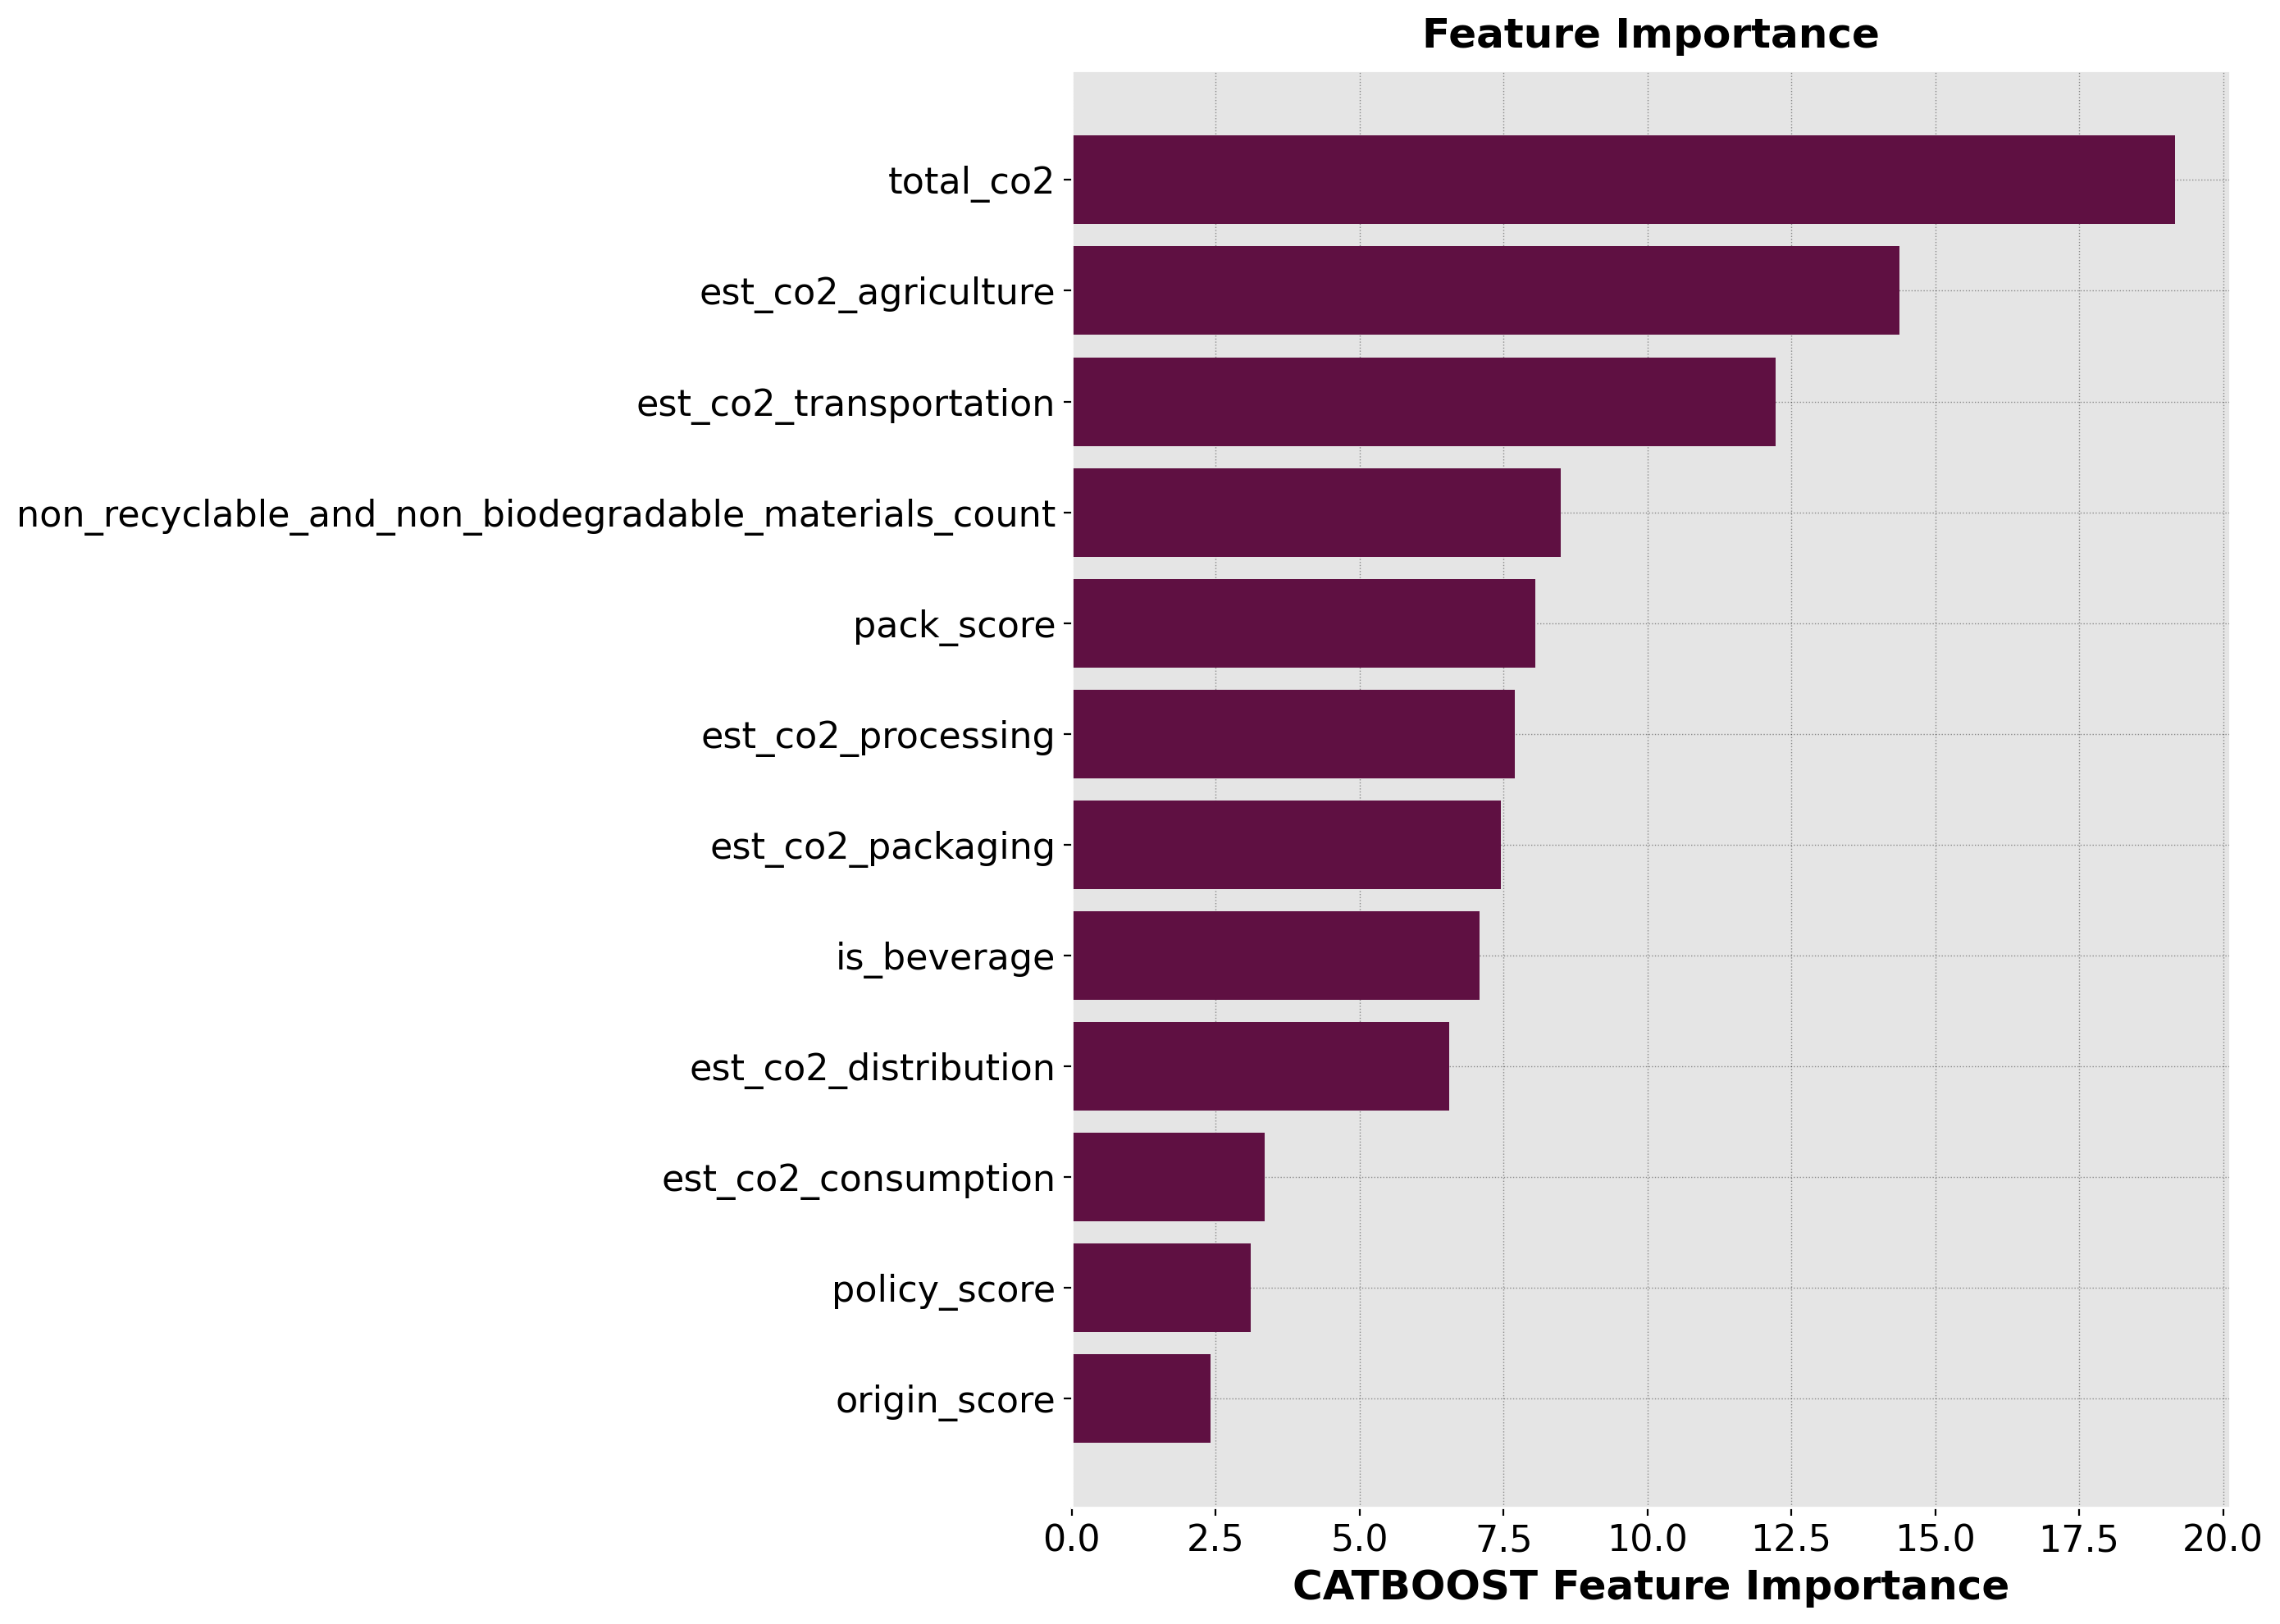

In [120]:
%%time
# Setting up fold parameters
splits = 10
skf = model_selection.StratifiedKFold(n_splits=splits, shuffle=True )

# Creating an array of zeros for storing "out of fold" predictions
oof_preds = np.zeros((X.shape[0],))

model_fi = 0
total_mean_acc = 0

# Generating folds and making training and prediction for each of 10 folds
for num, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = CatBoostClassifier(**cb_params)
    model.fit(X_train, y_train,
              verbose=False,
              eval_set=(X_valid, y_valid),
              )

    # Getting mean feature importances
    model_fi += model.feature_importances_ / splits

    # Getting validation data predictions.
    oof_preds[valid_idx] = model.predict(X_valid).flatten()

    # Getting score for a fold model
    fold_acc = f1_score(y_valid, oof_preds[valid_idx],average='macro')

    print(f"Fold {num} f1 score: {fold_acc}")
    print(classification_report(y_valid,oof_preds[valid_idx]))

    # Getting mean score of all fold models
    total_mean_acc += fold_acc / splits
cat_predict = pd.DataFrame(model.predict(test),index=test.index)
cat_predict
cat_predict.to_json(path_or_buf='cat_predict.json')

print(f"\nOverall F!: {total_mean_acc}")
plt.figure(figsize=(14,10))
idxs = np.argsort(model_fi)
plt.title("Feature Importance")
plt.barh(range(len(idxs)),model_fi[idxs],align="center",color = '#5f1042')
plt.yticks(range(len(idxs)),[X_train.columns[i] for i in idxs])
plt.xlabel("CATBOOST Feature Importance")
plt.tight_layout()
plt.show

Fold 0 accuracy: 0.8726207978832345
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       152
           1       0.96      0.89      0.92       642
           2       0.80      0.84      0.82       357
           3       0.89      0.85      0.87       609
           4       0.87      0.92      0.90       324

    accuracy                           0.88      2084
   macro avg       0.86      0.89      0.87      2084
weighted avg       0.88      0.88      0.88      2084

Fold 1 accuracy: 0.8723594328342215
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       152
           1       0.96      0.89      0.92       642
           2       0.77      0.80      0.79       357
           3       0.88      0.86      0.87       609
           4       0.89      0.93      0.91       324

    accuracy                           0.88      2084
   macro avg       0.86      0.89      0.87      2084
weigh

<function matplotlib.pyplot.show(close=None, block=None)>

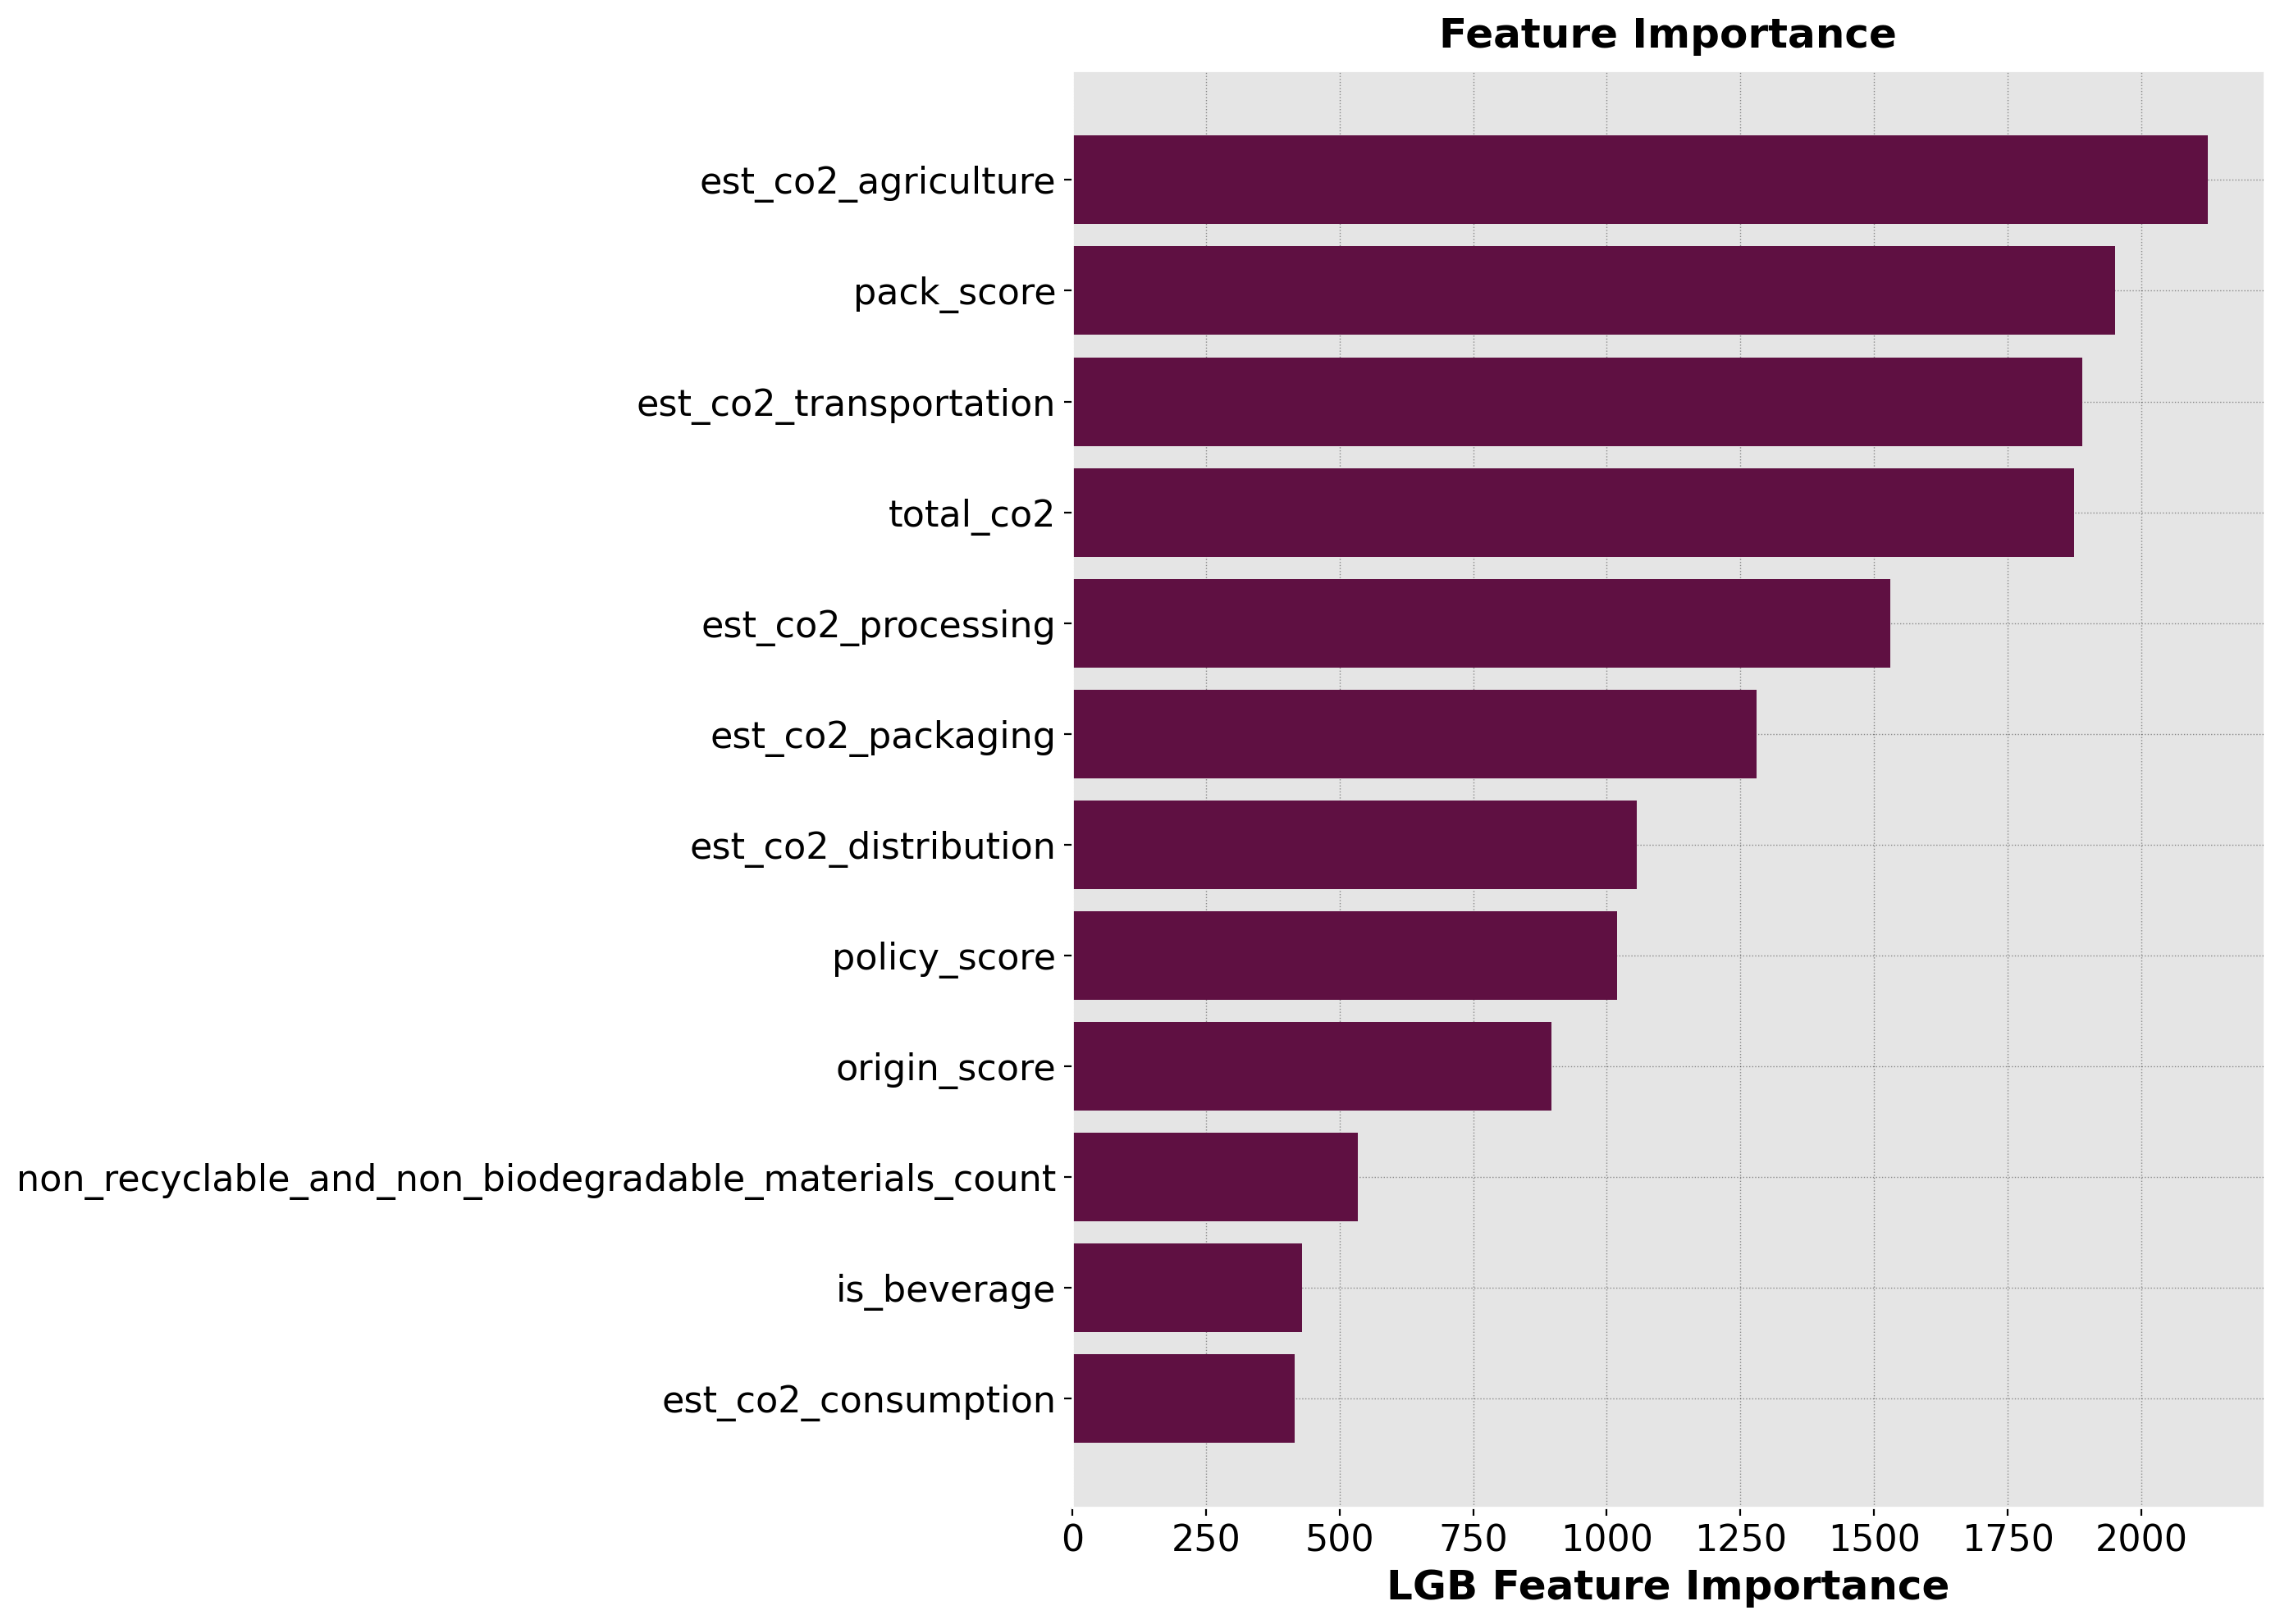

In [121]:
%%time
# Setting up fold parameters
splits = 10
skf = model_selection.StratifiedKFold(n_splits=splits, shuffle=True)

# Creating an array of zeros for storing "out of fold" predictions
oof_preds = np.zeros((X.shape[0],))

model_fi = 0
total_mean_acc = 0

# Generating folds and making training and prediction for each of 10 folds
for num, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = LGBMClassifier(**lgb_params,class_weight='balanced')
    model.fit(X_train, y_train,
              verbose=False,
              eval_set=(X_valid, y_valid),
              eval_metric=lgb_f1_score,)

    # Getting mean feature importances
    model_fi += model.feature_importances_ / splits

    # Getting validation data predictions.
    oof_preds[valid_idx] = model.predict(X_valid).flatten()

    # Getting score for a fold model
    fold_acc = f1_score(y_valid, oof_preds[valid_idx],average='macro')

    print(f"Fold {num} accuracy: {fold_acc}")
    print(classification_report(y_valid,oof_preds[valid_idx]))

    # Getting mean score of all fold models
    total_mean_acc += fold_acc / splits
lgb_predict = pd.DataFrame(model.predict(test),index=test.index)
lgb_predict.to_json(path_or_buf='lgb_predict.json')

print(f"\nOverall F1: {total_mean_acc}")
plt.figure(figsize=(14,10))
idxs = np.argsort(model_fi)
plt.title("Feature Importance")
plt.barh(range(len(idxs)),model_fi[idxs],align="center",color = '#5f1042')
plt.yticks(range(len(idxs)),[X_train.columns[i] for i in idxs])
plt.xlabel("LGB Feature Importance")
plt.tight_layout()
plt.show

In [122]:
test.columns

Index(['is_beverage', 'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'origin_score', 'policy_score', 'pack_score', 'total_co2'],
      dtype='object')

In [123]:
cat_predict.rename(columns={0:'target'})

,target
0,1
1,2
2,1
3,1
4,3
...,...
1267,1
1268,2
1269,1
1270,3


In [124]:

cat_predict.rename(columns={0:'target'},inplace=True)
lgb_predict.rename(columns={0:'target'},inplace=True)
cat_predict.to_json(path_or_buf='cat_predict.json')
lgb_predict.to_json(path_or_buf='lgb_predict.json')

In [129]:
%%time
cl2 = RandomForestClassifier()
cl5 = CatBoostClassifier( verbose = None, logging_level = 'Silent',task_type = 'GPU') #task_type = 'GPU',
cl6 = LGBMClassifier()#device = 'gpu'
models_scores_results, models_names = list(), list()
classifiers = {
    "RandomForest": cl2,
    "CatBoost": cl5,
    "LGBM": cl6,

}
FOLDS=6
print(">>>> Training started <<<<")
for key in classifiers:
    classifier = classifiers[key]
    scores = model_selection.cross_val_score(classifier, X, y, cv = FOLDS, scoring='f1_weighted')
    models_scores_results.append(scores)
    models_names.append(key)
    print("[%s] - accuracy: %0.5f " % (key, scores.mean()))
    classifier.fit(X, y)
    clf_predict = pd.DataFrame(classifier.predict(test),index=test.index)
    clf_predict.rename(columns={0:'target'},inplace=True)
    clf_predict.to_json(path_or_buf=f'{key}_predict.json')
    classifier.predict(test)

    # Save classifier for prediction
    classifiers[key] = classifier

>>>> Training started <<<<
[RandomForest] - accuracy: 0.88433 
[CatBoost] - accuracy: 0.88531 
[LGBM] - accuracy: 0.88545 
CPU times: user 1min 23s, sys: 29.6 s, total: 1min 53s
Wall time: 1min 15s


In [126]:
X.columns

Index(['is_beverage', 'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'origin_score', 'policy_score', 'pack_score', 'total_co2'],
      dtype='object')

In [127]:
test.columns

Index(['is_beverage', 'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'origin_score', 'policy_score', 'pack_score', 'total_co2'],
      dtype='object')